In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm as tqdm
import random
import os
import json
import numpy as np

import glasbey

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
from astropy.time import Time
from gaussian_process_example import *

from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_style('whitegrid')



df = pd.read_csv('gp_objects(downsample).csv')
obj = sorted(df.obj_id.unique())
for item in ['ztfg','ztfr','ztfi']:
    df.loc[df[f'mag_error_{item}'] < 0, f'mag_error_{item}'] = np.nan
    df.loc[df[f'mag_error_{item}'] > 1, f'mag_error_{item}'] = np.nan
df_observed = pd.read_csv('gp_objects_original_observations(matched).csv')
df_observed = df_observed[df_observed.t < 25]
df_observed = df_observed[df_observed.obj_id.isin(obj)]
display(df)
display(df_observed)
common_columns = ['obj_id', 'type', 'redshift', 'mjd', 'mjd_0', 't', 'mag_ztfg',
    'abs_mag_ztfg', 'mag_error_ztfg', 'mag_ztfr', 'abs_mag_ztfr',
    'mag_error_ztfr', 'mag_ztfi', 'abs_mag_ztfi', 'mag_error_ztfi',]
filters = ['ztfg', 'ztfr', 'ztfi']

df_rates = pd.read_csv('gp_objects_rates.csv').sort_values(by='type')
## switch any instances of "Kilonova" in type column to "AT2017gfo"
df_rates.loc[df_rates['type'] == 'Kilonova', 'type'] = 'AT2017gfo'

## use the labels from df_rates to rename the labels in df and df_observed
type_dict = df_rates.set_index('obj_id')['type'].to_dict()
df['type'] = df['obj_id'].map(type_dict)
df_observed['type'] = df_observed['obj_id'].map(type_dict)

df_rates_far = df_rates[df_rates['redshift'] > 0.001]
df_2019 = pd.read_csv('bulla_2019_rates.csv')
#df_rates.loc[df_rates['obj_id'] == 'ZTF24abvevzs', 'type'] = 'ZTF24abvevzs'

display(df_rates)
display(df_2019)


savefigs = True
ext = '.pdf'

types = df_rates['type'].unique()
## alphabetize
#types = sorted(types)
## reorder dictionary so "AT2017gfo" is last
types = [x for x in types if x != 'AT2017gfo'] + ["AT2017gfo"] if "AT2017gfo" in types else types
print('number of types:', len(types) - 1) ## to exclude AT2017gfo
colors = sns.color_palette("colorblind", n_colors=len(types))
colors = glasbey.create_palette(palette_size=len(types), colorblind_safe=True)
colors_dict = {types[i]: colors[i] for i in range(len(types))}
markers = ['o', 'D', '^', 'v', 's', '<', '>', 'p', 'P', '*', 'X', 'd', 'H', 'h', '+', 'x', '|', '_', '.']
type_style_dict = {types[i]: {'color': colors[i], 'marker': markers[i], "size":50, 'alpha':0.8, 'zorder':1} for i in range(len(types))}
if "AT2017gfo" in types:
    type_style_dict['AT2017gfo'] = {'color': 'lime', 'marker': '1', 'size': 300, 'alpha': 1, 'zorder': 100}
if "AT2025ulz" in types:
    type_style_dict['AT2025ulz'] = {'color': 'red', 'marker': '2', 'size': 300, 'alpha': 1, 'zorder': 100}

,mjd,flux_ztfg,flux_ztfi,flux_ztfr,flux_error_ztfg,flux_error_ztfi,flux_error_ztfr,type,obj_id,mjd_0,...,mag_error_ztfg,mag_ztfr,abs_mag_ztfr,mag_error_ztfr,mag_ztfi,abs_mag_ztfi,mag_error_ztfi,t,rise,fade
0,57983.231000,385.374906,440.341788,404.940209,29.250027,17.182907,24.797305,Kilonova,AT2017gfo,57983.231000,...,0.082408,17.381523,-15.832157,0.066487,17.290525,-15.923154,0.042367,0.000000,n,y
1,57983.239778,382.559484,438.232033,402.502588,28.789575,16.890215,24.361032,Kilonova,AT2017gfo,57983.231000,...,0.081707,17.388078,-15.825601,0.065713,17.295740,-15.917940,0.041846,0.008778,n,y
2,57983.248556,379.738177,436.119876,400.065220,28.332873,16.606597,23.927709,Kilonova,AT2017gfo,57983.231000,...,0.081009,17.394673,-15.819007,0.064937,17.300985,-15.912694,0.041343,0.017556,n,y
3,57983.257333,376.910979,434.005567,397.628148,27.879986,16.332054,23.497397,Kilonova,AT2017gfo,57983.231000,...,0.080312,17.401307,-15.812372,0.064160,17.306262,-15.907418,0.040857,0.026333,n,y
4,57983.266111,374.077886,431.889351,395.191413,27.430981,16.066587,23.070161,Kilonova,AT2017gfo,57983.231000,...,0.079617,17.407981,-15.805698,0.063382,17.311569,-15.902111,0.040390,0.035111,n,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38647,60907.149217,4.469360,8.209927,6.372631,0.852774,0.933342,0.788984,AT2025ulz,ZTF25abjmnps,60905.188368,...,0.207163,21.889203,-16.117900,0.134423,21.614152,-16.392951,0.123431,1.960849,n,y
38648,60907.151188,4.464836,8.206223,6.369248,0.857599,0.937690,0.792699,AT2025ulz,ZTF25abjmnps,60905.188368,...,0.208546,21.889780,-16.117323,0.135128,21.614642,-16.392461,0.124062,1.962820,n,y
38649,60907.153159,4.460324,8.202513,6.365864,0.862426,0.942046,0.796426,AT2025ulz,ZTF25abjmnps,60905.188368,...,0.209933,21.890357,-16.116746,0.135835,21.615133,-16.391970,0.124695,1.964791,n,y
38650,60907.155129,4.455825,8.198797,6.362478,0.867257,0.946410,0.800164,AT2025ulz,ZTF25abjmnps,60905.188368,...,0.211322,21.890934,-16.116168,0.136545,21.615625,-16.391478,0.125330,1.966761,n,y


,obj_id,type,redshift,mjd,mjd_0,t,mag_ztfg,abs_mag_ztfg,mag_error_ztfg,mag_ztfr,abs_mag_ztfr,mag_error_ztfr,mag_ztfi,abs_mag_ztfi,mag_error_ztfi
0,AT2017gfo,Kilonova,0.00984,57983.231000,57983.231000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,17.240000,-15.973680,0.060000
1,AT2017gfo,Kilonova,0.00984,57983.420000,57983.231000,0.189000,17.46,-15.753680,0.08,NaN,NaN,NaN,NaN,NaN,NaN
2,AT2017gfo,Kilonova,0.00984,57983.420000,57983.231000,0.189000,NaN,NaN,NaN,17.320000,-15.893680,0.070000,NaN,NaN,NaN
3,AT2017gfo,Kilonova,0.00984,57983.420000,57983.231000,0.189000,NaN,NaN,NaN,NaN,NaN,NaN,17.420000,-15.793680,0.050000
4,AT2017gfo,Kilonova,0.00984,57983.758000,57983.231000,0.527000,18.05,-15.163680,0.12,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,ZTF25abjmnps,AT2025ulz,0.08480,60906.840119,60905.188368,1.651751,NaN,NaN,NaN,NaN,NaN,NaN,21.487565,-16.519537,0.082794
9457,ZTF25abjmnps,AT2025ulz,0.08480,60906.906590,60905.188368,1.718222,22.11,-15.897103,0.17,NaN,NaN,NaN,NaN,NaN,NaN
9458,ZTF25abjmnps,AT2025ulz,0.08480,60906.912390,60905.188368,1.724022,NaN,NaN,NaN,21.750000,-16.257103,0.140000,NaN,NaN,NaN
9459,ZTF25abjmnps,AT2025ulz,0.08480,60906.918160,60905.188368,1.729792,NaN,NaN,NaN,NaN,NaN,NaN,21.610000,-16.397103,0.110000


,obj_id,type,category,redshift,ztfg_peak_time,ztfg_peak_mag,ztfr_peak_time,ztfr_peak_mag,ztfi_peak_time,ztfi_peak_mag,...,ztfr_rise_duration,ztfr_rise_rate,ztfi_rise_duration,ztfi_rise_rate,ztfg_fade_duration,ztfg_fade_rate,ztfr_fade_duration,ztfr_fade_rate,ztfi_fade_duration,ztfi_fade_rate
69,ZTF25abjmnps,AT2025ulz,AT2025ulz,0.08480,0.000000,-16.848637,0.000000,-16.710861,0.000000,-16.512919,...,NaN,NaN,NaN,NaN,1.968732,0.569050,1.968732,0.302362,1.968732,0.061935
27,ZTF20acozryr,Afterglow,Afterglow,1.10500,0.000000,-24.982499,0.000000,-25.159879,NaN,NaN,...,NaN,NaN,NaN,NaN,0.976551,0.541711,0.976551,0.622483,NaN,NaN
38,ZTF21abfmpwn,Afterglow,Afterglow,1.13450,0.000000,-25.995617,0.000000,-26.251762,NaN,NaN,...,NaN,NaN,NaN,NaN,1.101111,2.108729,1.101111,2.029503,NaN,NaN
41,ZTF22aabjpxh,Afterglow,Afterglow,0.29300,0.000000,-24.202251,0.000000,-24.375539,0.000000,-24.383250,...,NaN,NaN,NaN,NaN,1.010741,2.842063,1.010741,2.411686,1.010741,1.944579
57,ZTF23aaoohpy,Afterglow,Afterglow,1.02700,0.244034,-24.708486,0.181406,-24.958452,NaN,NaN,...,0.181406,-0.464425,NaN,NaN,0.834682,1.079221,0.897310,1.172814,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,ZTF20acgigfo,Novae,Galactic,0.00017,3.304714,-6.844664,3.121119,-7.332601,NaN,NaN,...,3.121119,-0.425147,NaN,NaN,1.973649,0.648745,1.973649,0.646859,NaN,NaN
49,ZTF22abijszk,Novae,Galactic,0.00100,0.000000,-8.016094,0.000000,-9.144732,NaN,NaN,...,NaN,NaN,NaN,NaN,1.934028,1.067826,1.934028,0.475787,NaN,NaN
48,ZTF22abfxmpc,Novae,Galactic,0.00000,0.793516,2.836526,0.793516,2.802224,1.058021,2.873734,...,0.793516,-0.183027,1.058021,-0.128745,1.983790,0.778070,1.983790,0.206140,1.939705,0.056325
46,ZTF22aazmooy,Novae,Galactic,0.00017,1.462144,-6.973774,1.305485,-7.384998,1.357705,-7.431442,...,1.305485,-0.837569,1.357705,-0.821712,1.984338,0.568944,1.984338,0.469871,1.984338,0.406810


,ztfg_peak_mag,ztfg_peak_time,ztfg_rise_rate,ztfg_fade_rate,ztfg_fwhm,ztfg_rise_hwhm,ztfg_fade_hwhm,ztfr_peak_mag,ztfr_peak_time,ztfr_rise_rate,...,ztfi_rise_hwhm,ztfi_fade_hwhm,ztfg_peak_gr_color,ztfg_peak_gi_color,ztfr_peak_gr_color,ztfr_peak_ri_color,ztfi_peak_gi_color,ztfi_peak_ri_color,model,obj_id
0,-14.803,0.5,NaN,1.182000,NaN,NaN,NaN,-15.659,0.5,NaN,...,NaN,NaN,0.856,0.903,0.856,0.047,0.903,0.047,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta0.00_dMpc0
1,-14.730,0.5,NaN,1.165333,NaN,NaN,NaN,-15.582,0.5,NaN,...,NaN,NaN,0.852,0.903,0.852,0.051,0.903,0.051,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta25.84_d...
2,-14.655,0.5,NaN,1.149333,NaN,NaN,NaN,-15.505,0.5,NaN,...,NaN,NaN,0.850,0.910,0.850,0.060,0.910,0.060,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta36.87_d...
3,-14.578,0.5,NaN,1.130000,NaN,NaN,NaN,-15.429,0.5,NaN,...,NaN,NaN,0.851,0.913,0.851,0.062,0.913,0.062,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta45.57_d...
4,-14.501,0.5,NaN,1.108000,NaN,NaN,NaN,-15.355,0.5,NaN,...,NaN,NaN,0.854,0.916,0.854,0.062,0.916,0.062,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta53.13_d...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,-13.058,2.5,-0.7430,0.028000,4.5,1.0,3.5,-13.853,3.0,-0.7204,...,1.5,5.0,0.762,1.264,0.837,0.512,1.380,0.526,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta66.42_d...
2196,-13.039,2.5,-0.7495,0.016667,4.5,1.0,3.5,-13.845,3.0,-0.7248,...,1.5,5.0,0.771,1.273,0.831,0.515,1.389,0.537,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta72.54_d...
2197,-13.029,2.5,-0.7520,0.010667,4.5,1.0,3.5,-13.841,3.0,-0.7208,...,1.5,5.0,0.779,1.278,0.828,0.514,1.386,0.534,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta78.46_d...
2198,-13.029,2.5,-0.7565,0.014000,4.5,1.0,3.5,-13.841,3.0,-0.7120,...,1.5,5.0,0.776,1.277,0.833,0.513,1.384,0.530,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta84.26_d...


number of types: 12


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/8_/ky643qs168ngjmhrpwcq1fdm0000gn/T/ipykernel_52169/825060088.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(axs.get_xticklabels(), rotation=45, ha='right')


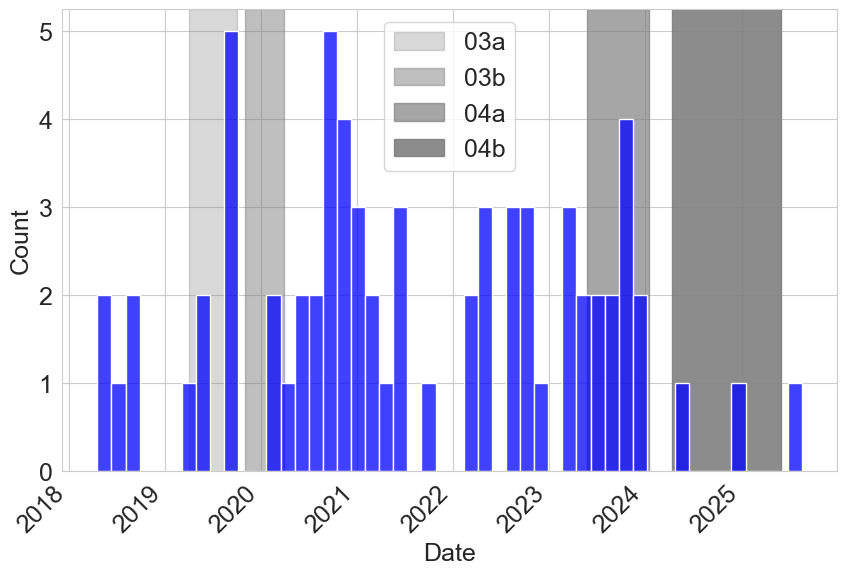

In [2]:
plt.rcParams.update({'font.size': 18})
# Use mjd_0 value to plot the number of objects over time. Only plot the unique objects.
df_count = df_observed[df_observed.obj_id != 'AT2017gfo'].groupby('obj_id').mjd_0.min().reset_index()
df_count['mjd_0'] = Time(df_count['mjd_0'], format='mjd').to_value('iso')
plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.axvspan(pd.Timestamp('2019-04-01'), pd.Timestamp('2019-10-01'), color='gray', alpha=0.3, label='03a')
plt.axvspan(pd.Timestamp('2019-11-01'), pd.Timestamp('2020-03-27'), color='gray', alpha=0.5, label='03b')
plt.axvspan(pd.Timestamp('2023-05-23'), pd.Timestamp('2024-01-16'), color='gray', alpha=0.7, label='04a')
plt.axvspan(pd.Timestamp('2024-04-10'), pd.Timestamp('2025-06-01'), color='gray', alpha=0.90, label='04b')
sns.histplot(pd.to_datetime(df_count['mjd_0']), bins=50, color='blue',)
axs.set_xticklabels(axs.get_xticklabels(), rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Count')
#plt.title('Potential Kilonovae from ZTFReST')
plt.legend();
plt.savefig(f'figures/candidate_kne_hist{ext}') if savefigs else None

In [3]:
## make a dataframe that consists of the unique objects, their type, their redshift, and the date of their first observation
df_unique_obj = df_observed[df_observed.obj_id != 'AT2017gfo'].groupby('obj_id').mjd_0.min().reset_index()
df_unique_obj['mjd_0'] = Time(df_unique_obj['mjd_0'], format='mjd').to_value('iso')
## drop time, just use date
df_unique_obj['mjd_0'] = df_unique_obj['mjd_0'].apply(lambda x: x.split(' ')[0])
df_unique_obj.rename(columns={'mjd_0':'first_observation'}, inplace=True)
df_unique_obj = df_unique_obj.merge(df_observed[['obj_id', 'type', 'redshift']].drop_duplicates(), on='obj_id')
display(df_unique_obj)
#df_unique_obj.to_csv('paper_objects.csv', index=False)

,obj_id,first_observation,type,redshift
0,ZTF18aakuewf,2018-04-18,Ibn,0.063600
1,ZTF18aalrxas,2018-04-19,IIb,0.058200
2,ZTF18abffyqp,2018-07-08,II,0.031000
3,ZTF18abvkmgw,2018-09-12,Ib,0.038470
4,ZTF18abwkrbl,2018-09-15,IIb,0.009990
...,...,...,...,...
64,ZTF23absbqun,2023-12-07,Ib,0.010100
65,ZTF23abtycgb,2023-12-14,II,0.020127
66,ZTF24aascytf,2024-06-15,II,0.038000
67,ZTF24abvevzs,2024-12-02,IIb,0.035000


In [4]:
## average number of observations per object
print('average number of observations per object')
print(df_observed.groupby('obj_id').size().mean())

average number of observations per object
36.34285714285714


In [5]:
## breakdown of percent of observations per filter. found by counting the number of items with a non-nan value for each filter column
print('breakdown of percent of observations per filter')
for item in filters:
    print(item)
    print(df_observed[f'mag_{item}'].count()/len(df_observed))

breakdown of percent of observations per filter
ztfg
0.46855345911949686
ztfr
0.45440251572327045
ztfi
0.0770440251572327


In [6]:
df_observed[df_observed.t < 25].groupby('obj_id')['t'].diff().describe()

count    2474.000000
mean        0.448331
std         1.209899
min         0.000000
25%         0.000000
50%         0.004919
75%         0.092853
max        18.920289
Name: t, dtype: float64

In [7]:
df_observed.groupby('obj_id')['t'].describe()

,count,mean,std,min,25%,50%,75%,max
obj_id,,,,,,,,
AT2017gfo,35.0,2.702743,2.594591,0.0,0.869000,1.738000,3.243000,8.769000
ZTF18aakuewf,70.0,8.011597,5.808719,0.0,4.022263,7.061377,10.991270,21.959028
ZTF18aalrxas,57.0,12.638434,7.883201,0.0,4.023889,15.922639,19.932014,22.924445
ZTF18abffyqp,113.0,12.965703,7.358590,0.0,7.013056,14.078785,18.994039,24.096273
ZTF18abvkmgw,23.0,5.366637,3.146875,0.0,2.950839,4.994224,7.966314,11.903345
...,...,...,...,...,...,...,...,...
ZTF23absbqun,18.0,3.327628,2.002244,0.0,1.989768,3.055336,4.901296,7.121586
ZTF23abtycgb,26.0,4.930443,7.173073,0.0,0.378472,2.010515,3.017326,22.014398
ZTF24aascytf,36.0,1.620700,2.589857,0.0,0.136481,0.185058,1.390570,9.123403


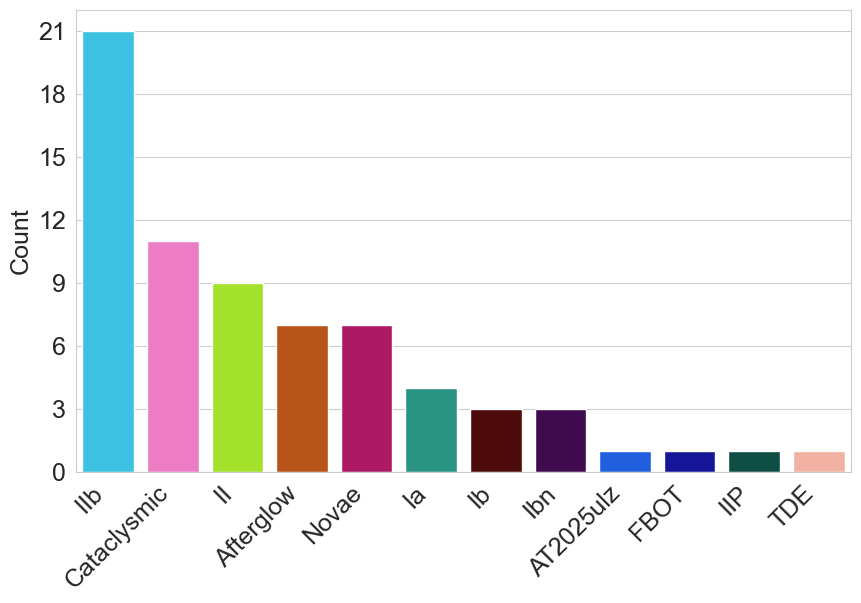

In [8]:
from matplotlib.ticker import MaxNLocator
type_counts = df_rates[df_rates.type != 'AT2017gfo']['type'].value_counts()
sorted_types = type_counts.index
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
sns.set_style('whitegrid')
sns.countplot(data=df_rates[df_rates.type != 'AT2017gfo'], x='type', order=sorted_types, palette=colors_dict, ax=axs)
axs.set_xticklabels(axs.get_xticklabels(), rotation=45, ha='right')
# sns.set(style='whitegrid')
axs.set_xlabel('')
axs.set_ylabel('Count')
axs.yaxis.set_major_locator(MaxNLocator(integer=True))
#ax.grid(axis='y')
axs.set_ylim(0,22)
plt.savefig(f'figures/type_distribution{ext}', bbox_inches='tight') if savefigs else None
plt.show()

Color at Peak

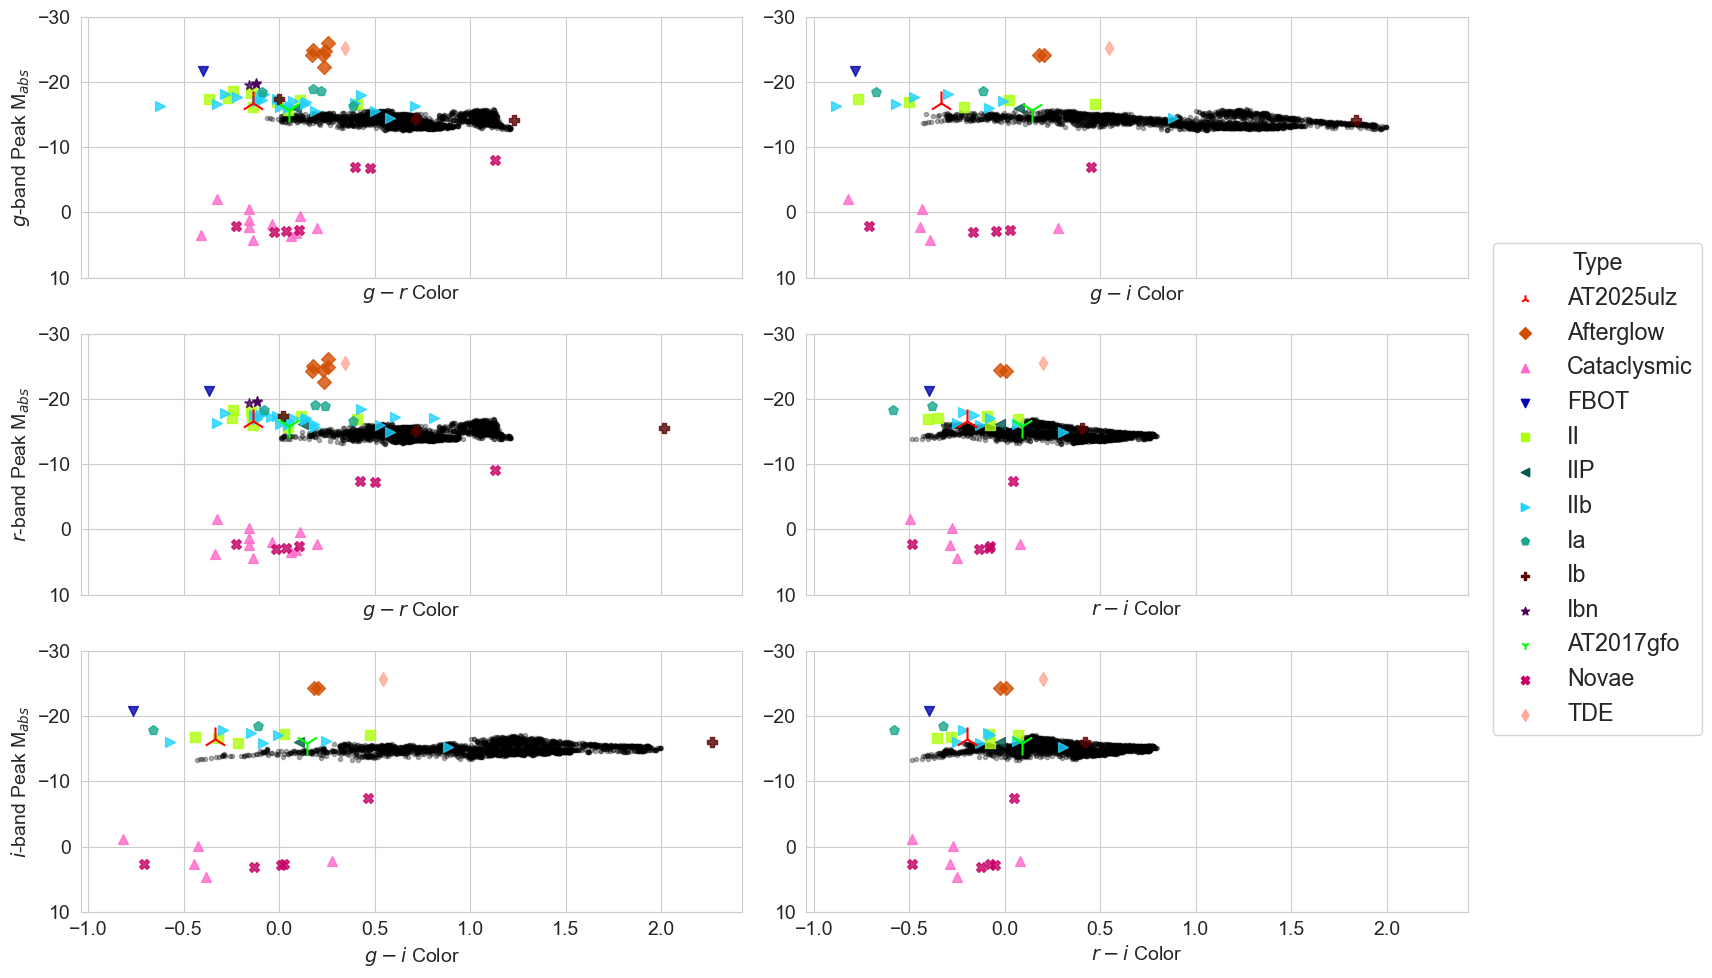

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex=True)

axs = axs.flatten()

peaks = ['ztfg_peak_gr_color', 'ztfg_peak_gi_color', 
         'ztfr_peak_gr_color', 'ztfr_peak_ri_color', 
         'ztfi_peak_gi_color', 'ztfi_peak_ri_color']
axs2 = []
for ax, peak in zip(axs, peaks):
    filter = peak.split('_')[0]

    # Plot the data on both axes
    ax.scatter(df_2019[peak], df_2019[f'{filter}_peak_mag'], alpha=0.3, color='k', marker='.')
    # ax2.scatter(df_2019[peak], df_2019[f'{filter}_peak_mag'], alpha=0.3, color='k', marker='.')

    for type_ in df_rates['type'].unique():
        df_class = df_rates[(df_rates['type'] == type_) & (df_rates[f'{filter}_peak_mag'].notnull())]
        if len(df_class) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            ax.scatter(df_class[peak], df_class[f'{filter}_peak_mag'], 
                       color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
            # ax2.scatter(df_class[peak], df_class[f'{filter}_peak_mag'], 
            #            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
            


## add legend to the right of the plots using the type_style_dict colors and markers (base on all of the subplots)
handles, labels = [], []
for ax in axs:
    for type_ in df_rates['type'].unique():
        handles.append(ax.scatter([], [], color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker']))
        labels.append(type_)
handles = handles[:len(df_rates['type'].unique())]
labels = labels[:len(df_rates['type'].unique())]
fig.legend(handles, labels, loc='center right', title='Type', title_fontsize='large', fontsize='large', bbox_to_anchor=(1.15, 0.5),)

axs[0].set_ylabel("$\it{g}$-band Peak M$_{abs}$"), axs[2].set_ylabel("$\it{r}$-band Peak M$_{abs}$"), axs[4].set_ylabel("$\it{i}$-band Peak M$_{abs}$"); 

axs[0].set_xlabel("$\it{g-r}$ Color"), axs[1].set_xlabel("$\it{g-i}$ Color"); 
axs[2].set_xlabel("$\it{g-r}$ Color"), axs[3].set_xlabel("$\it{r-i}$ Color"); 
axs[4].set_xlabel("$\it{g-i}$ Color"), axs[5].set_xlabel("$\it{r-i}$ Color"); 
[subfig.set_ylim(10,-30) for subfig in axs]
ax.figure.tight_layout() 
plt.savefig(f'figures/peak_color_vs_peak_mag{ext}', bbox_inches='tight') if savefigs else None 
plt.show();

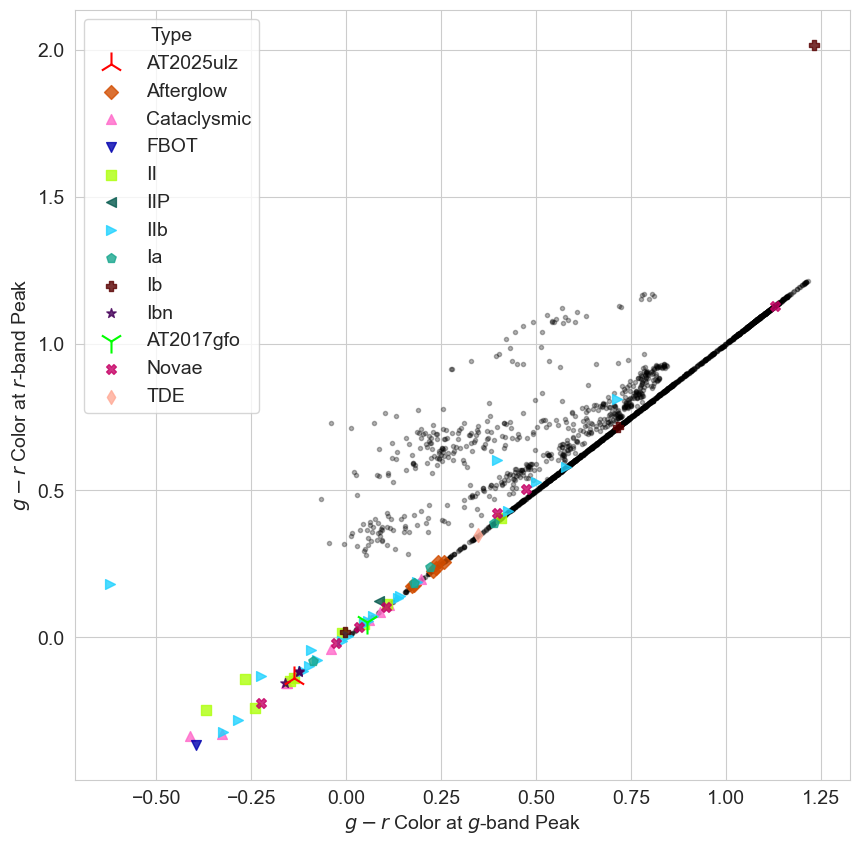

In [10]:
## compare the gr color at the peak of ztfg and the peak of ztfr
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
# ax.invert_yaxis()
axs.scatter(df_2019['ztfg_peak_gr_color'], df_2019['ztfr_peak_gr_color'], alpha=0.3, color='k',marker='.')

for type_ in df_rates['type'].unique():
    df_class = df_rates[(df_rates['type'] == type_) & (df_rates['ztfg_peak_gr_color'].notnull()) & (df_rates['ztfr_peak_gr_color'].notnull())]
    if len(df_class) > 0:
        s_ = type_style_dict[type_]['size']
        a_ = type_style_dict[type_]['alpha']
        c_ = type_style_dict[type_]['color']
        m_ = type_style_dict[type_]['marker']
        z_ = type_style_dict[type_]['zorder']
        axs.scatter(df_class['ztfg_peak_gr_color'], df_class['ztfr_peak_gr_color'],
                        color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
axs.legend(title='Type')
axs.set_xlabel("$\it{g-r}$ Color at $\it{g}$-band Peak")
axs.set_ylabel("$\it{g-r}$ Color at $\it{r}$-band Peak")
plt.savefig(f'figures/gr_color_at_g_vs_r_peak{ext}', bbox_inches='tight') if savefigs else None
plt.show();

FWHM vs Peak Magnitude

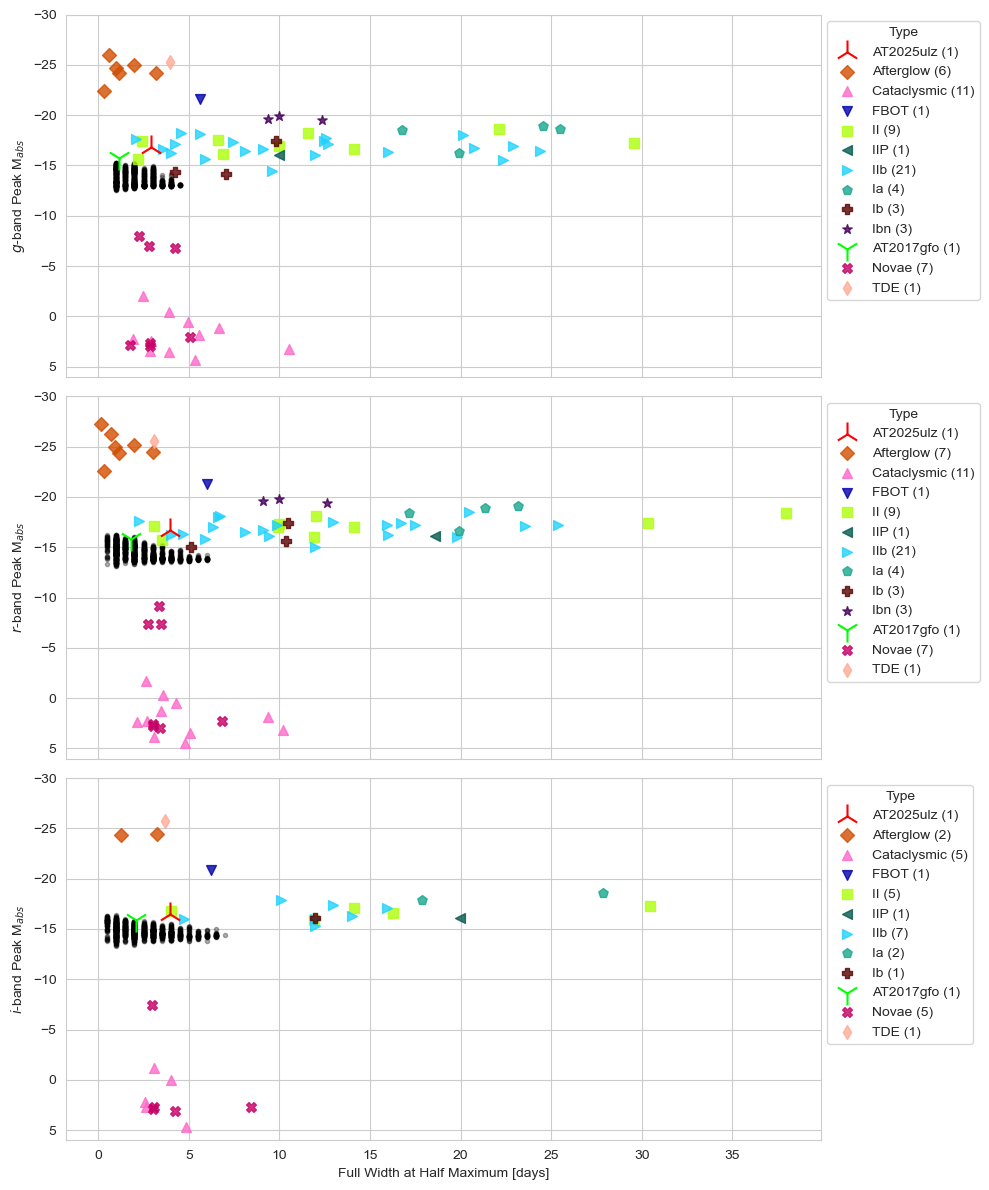

In [11]:
plt.rcParams.update({'font.size': 10})

## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']

## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates
fig, axs = plt.subplots(3, 1, figsize=(10, 12), 
                       sharex=True,sharey=True, tight_layout=True)
axs2 = []
# ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    
    axs[axi].scatter(df_2019[f'{filter}_fwhm'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')

    for type_ in df_rates['type'].unique():

        df_class = df_rates[(df_rates['type'] == type_) & (df_rates[f'{filter}_peak_mag'].notnull()) & (df_rates[f'{filter}_fwhm'].notnull())]
        if len(df_class) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            axs[axi].scatter(df_class[f'{filter}_fwhm'], df_class[f'{filter}_peak_mag'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)


#ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();

class_counts_ztfg = df_rates[df_rates['ztfg_fwhm'].notnull() & df_rates['ztfg_peak_mag'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[df_rates['ztfr_fwhm'].notnull() & df_rates['ztfr_peak_mag'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[df_rates['ztfi_fwhm'].notnull() & df_rates['ztfi_peak_mag'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(axs, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")

    
axs[0].set_ylabel("$\it{g}$-band Peak M$_{abs}$"), axs[1].set_ylabel("$\it{r}$-band Peak M$_{abs}$"), axs[2].set_ylabel("$\it{i}$-band Peak M$_{abs}$"); 
axs[0].set_xlabel(""), axs[0].set_xlabel(""), axs[2].set_xlabel("Full Width at Half Maximum [days]");
#ax[0].invert_xaxis(), ax[1].invert_xaxis(), ax[2].invert_xaxis();
#ax[0].set_xlim(None,-2.0)
[subfig.set_ylim(6,-30) for subfig in axs]
plt.savefig(f'figures/fwhm_vs_peak_luminosity{ext}', bbox_inches='tight') if savefigs else None

plt.show()

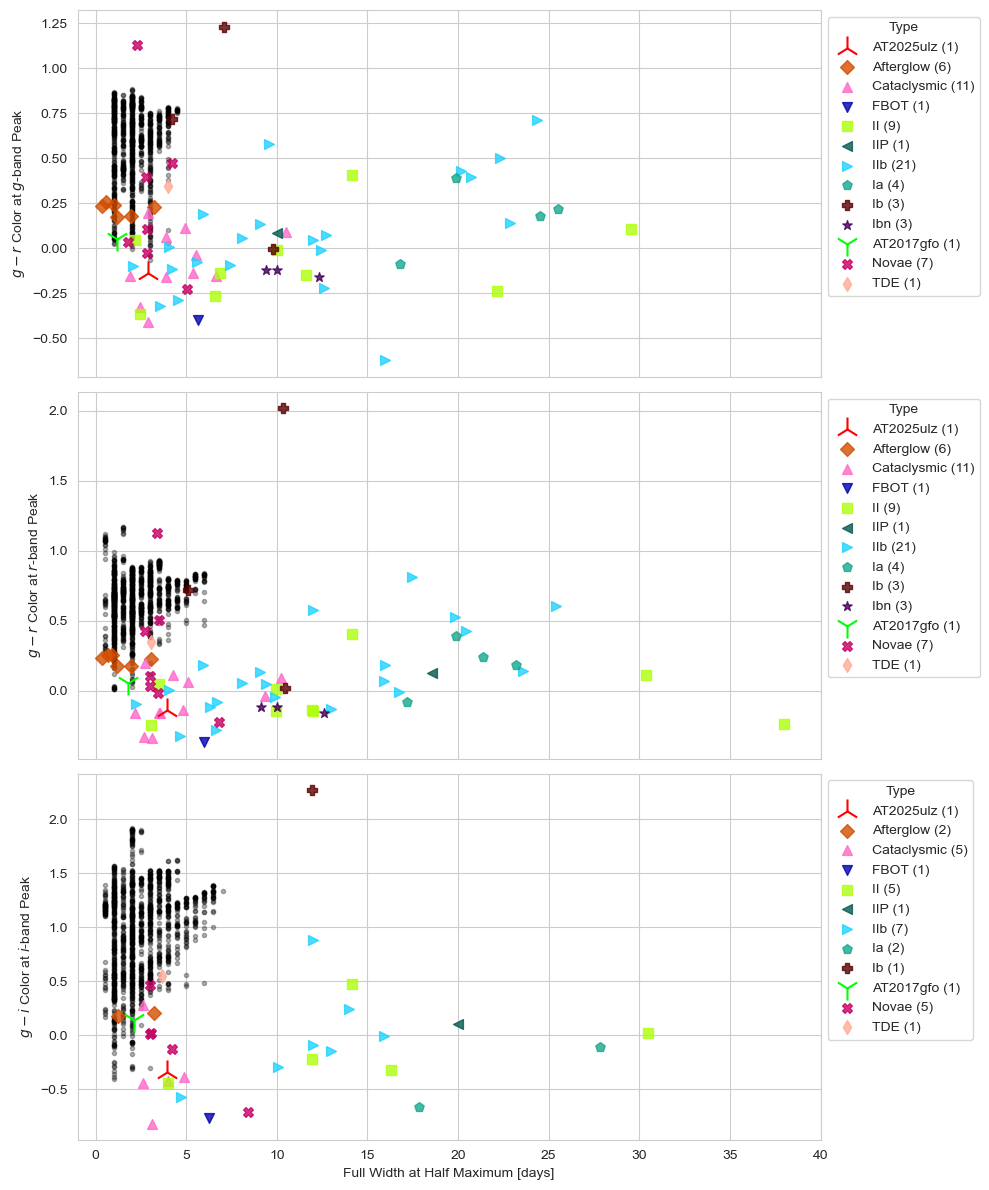

In [12]:
## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']

## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates
fig, axs = plt.subplots(3, 1, figsize=(10, 12), tight_layout=True,
                       sharex=True)#,sharey=True)
# ax[0].grid(), ax[1].grid(), ax[2].grid()


x_array = ['ztfg_fwhm', 'ztfr_fwhm', 'ztfi_fwhm']
y_array = ['ztfg_peak_gr_color', 'ztfr_peak_gr_color', 'ztfi_peak_gi_color']
for axi, (x, y) in enumerate(zip(x_array, y_array)):

    #axs[axi].hlines(0, -50, 50, color='k', linestyle='--', alpha=0.7,zorder=0)
    axs[axi].scatter(df_2019[x], df_2019[y], alpha=0.3,color='k',marker='.')
    df_class = df_rates[(df_rates[x].notnull()) & (df_rates[y].notnull())]

    for type_ in df_rates['type'].unique():
        df_class_type = df_class[df_class['type'] == type_]
        if len(df_class_type) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            axs[axi].scatter(df_class_type[x],  df_class_type[y],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
    

#ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();

class_counts_ztfg = df_rates[(df_rates['ztfg_fwhm'].notnull()) & (df_rates['ztfg_peak_gr_color'].notnull())]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[df_rates['ztfr_fwhm'].notnull() & df_rates['ztfr_peak_gr_color'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[df_rates['ztfi_fwhm'].notnull() & df_rates['ztfi_peak_gi_color'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(axs, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
# ax[0].set_ylabel("$\it{g-r}$ Color at $\it{g}$-band Peak"), ax[1].set_ylabel("$\it{r-g}$ Color at $\it{r}$-band Peak"), ax[2].set_ylabel("$\it{i-g}$ Color at $\it{i}$-band Peak") ## without color factor labels
axs[0].set_ylabel("$\it{g-r}$ Color at $\it{g}$-band Peak"), axs[1].set_ylabel("$\it{g-r}$ Color at $\it{r}$-band Peak"), axs[2].set_ylabel("$\it{g-i}$ Color at $\it{i}$-band Peak")
axs[0].set_xlabel(""), axs[0].set_xlabel(""), axs[2].set_xlabel("Full Width at Half Maximum [days]");
axs[0].set_xlim(-1, 40)

plt.savefig(f'figures/fwhm_vs_peak_color{ext}', bbox_inches='tight') if savefigs else None
plt.show()

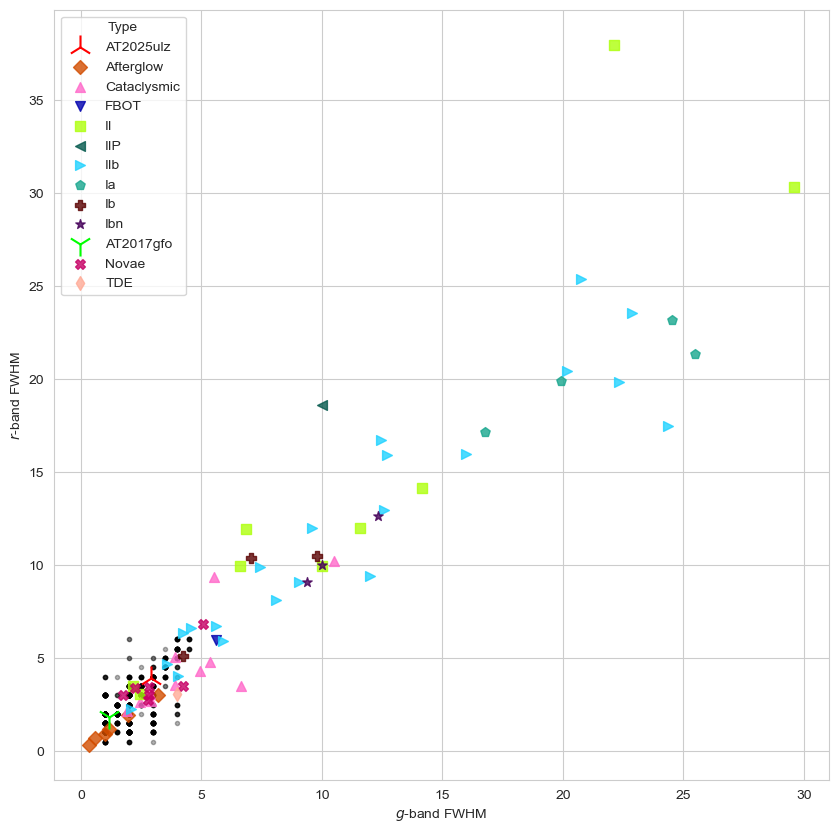

In [13]:
## compare the gr color at the peak of ztfg and the peak of ztfr
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
# ax.invert_yaxis()
# ax.grid()
axs.scatter(df_2019['ztfg_fwhm'], df_2019['ztfr_fwhm'], alpha=0.3, color='k',marker='.')

for type_ in df_rates['type'].unique():
    df_class = df_rates[(df_rates['type'] == type_) & (df_rates['ztfg_fwhm'].notnull()) & (df_rates['ztfr_fwhm'].notnull())]
    if len(df_class) > 0:
        s_ = type_style_dict[type_]['size']
        a_ = type_style_dict[type_]['alpha']
        c_ = type_style_dict[type_]['color']
        m_ = type_style_dict[type_]['marker']
        z_ = type_style_dict[type_]['zorder']
        axs.scatter(df_class['ztfg_fwhm'], df_class['ztfr_fwhm'],
                        color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
axs.legend(title='Type')
axs.set_xlabel("$\it{g}$-band FWHM");
axs.set_ylabel("$\it{r}$-band FWHM");
# plt.savefig(f'figures/ztfg_fwhm_vs_ztfr_fwhm{ext}', bbox_inches='tight')
plt.show();

Rise vs Peak Magnitude

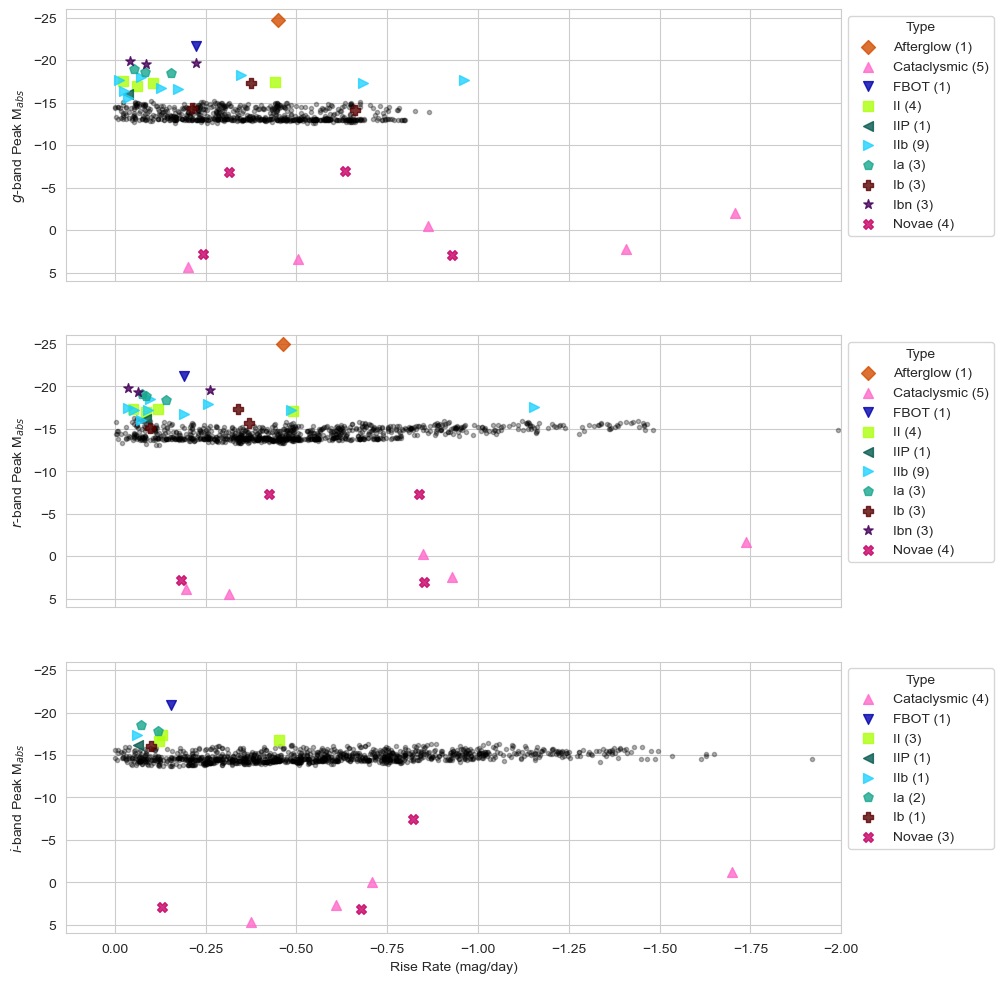

In [14]:
## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']

## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates
fig, axs = plt.subplots(3, 1, figsize=(10, 12), 
                       sharex=True,sharey=True)
# ax[0].grid(), ax[1].grid(), ax[2].grid()
axs2 = []
for axi, filter in enumerate(filters):
    axs[axi].invert_yaxis()

    
    axs[axi].scatter(df_2019[f'{filter}_rise_rate'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')

    for type_ in df_rates['type'].unique():
        df_class = df_rates[(df_rates['type'] == type_) & (df_rates[f'{filter}_peak_mag'].notnull()) & (df_rates[f'{filter}_rise_rate'].notnull())]
        if len(df_class) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            axs[axi].scatter(df_class[f'{filter}_rise_rate'], df_class[f'{filter}_peak_mag'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)

    

#ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
#ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates[df_rates['ztfg_rise_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[df_rates['ztfr_rise_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[df_rates['ztfi_rise_rate'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(axs, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
axs[0].set_ylabel("$\it{g}$-band Peak M$_{abs}$"), axs[1].set_ylabel("$\it{r}$-band Peak M$_{abs}$"), axs[2].set_ylabel("$\it{i}$-band Peak M$_{abs}$"); 
axs[0].set_xlabel(""), axs[0].set_xlabel(""), axs[2].set_xlabel("Rise Rate (mag/day)");
axs[0].invert_xaxis(), axs[1].invert_xaxis(), axs[2].invert_xaxis();
[subfig.set_ylim(6,-26) for subfig in axs]
axs[0].set_xlim(None,-2.0)
plt.savefig(f'figures/rise_rate_vs_peak_luminosity{ext}', bbox_inches='tight') if savefigs else None
plt.show()

Fade vs Peak Magnitude

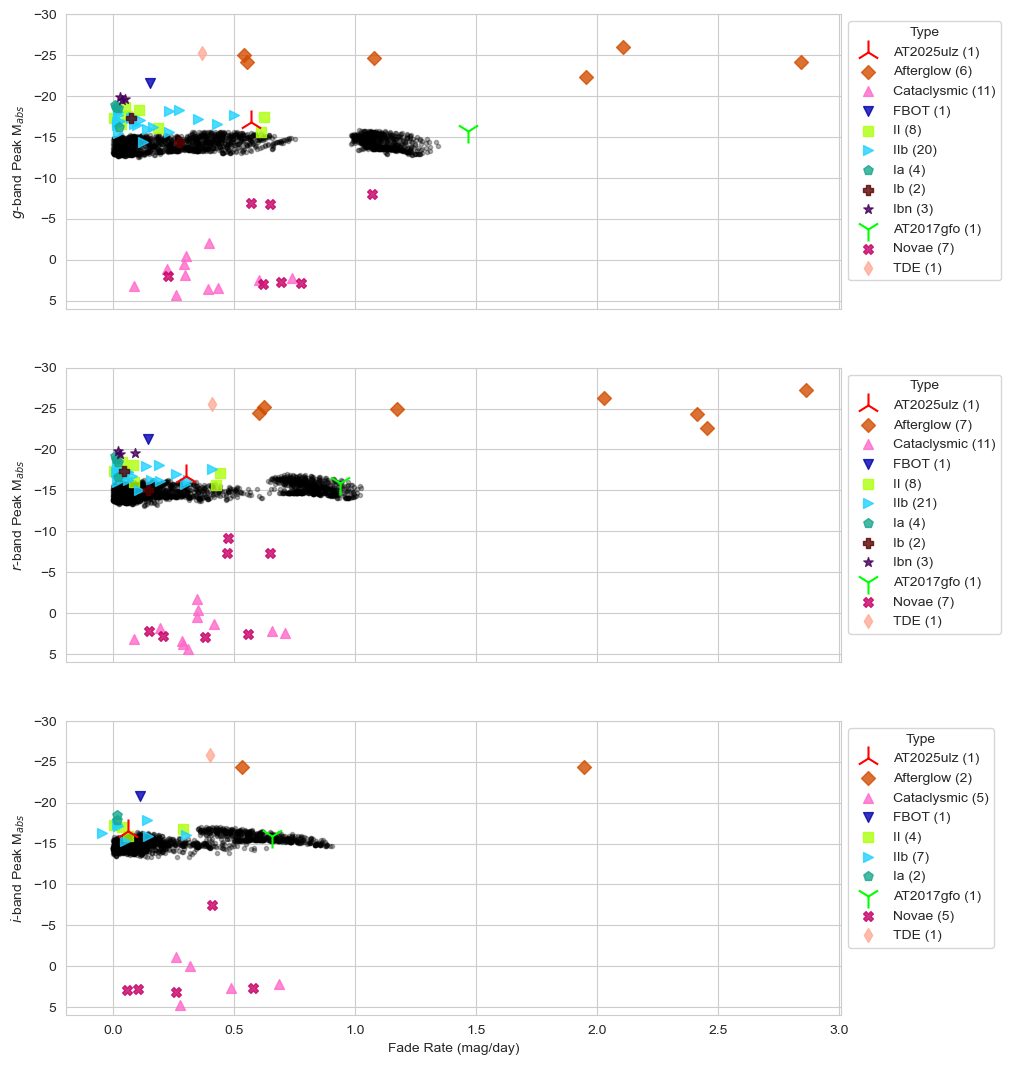

In [15]:
## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']

## plot the rate of fade vs the peak magnitude for each object in each filter using df_rates
fig, axs = plt.subplots(3, 1, figsize=(10, 13), 
                       sharex=True,sharey=True)
# ax[0].grid(), ax[1].grid(), ax[2].grid()

for axi, filter in enumerate(filters):
    axs[axi].invert_yaxis()

    
    axs[axi].scatter(df_2019[f'{filter}_fade_rate'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')

    for type_ in df_rates['type'].unique():
        df_class = df_rates[(df_rates['type'] == type_) & (df_rates[f'{filter}_peak_mag'].notnull()) & (df_rates[f'{filter}_fade_rate'].notnull())]
        if len(df_class) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            axs[axi].scatter(df_class[f'{filter}_fade_rate'], df_class[f'{filter}_peak_mag'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)

    

#ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
#ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates[df_rates['ztfg_fade_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[df_rates['ztfr_fade_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[df_rates['ztfi_fade_rate'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(axs, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
axs[0].set_ylabel("$\it{g}$-band Peak M$_{abs}$"), axs[1].set_ylabel("$\it{r}$-band Peak M$_{abs}$"), axs[2].set_ylabel("$\it{i}$-band Peak M$_{abs}$"); 
axs[0].set_xlabel(""), axs[0].set_xlabel(""), axs[2].set_xlabel("Fade Rate (mag/day)");
#ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
# axs[0].set_xlim(-0.2,3.0)
[subfig.set_ylim(6,-30) for subfig in axs]
plt.savefig(f'figures/fade_rate_vs_peak_luminosity{ext}', bbox_inches='tight') if savefigs else None
plt.show()

Rise vs Fade

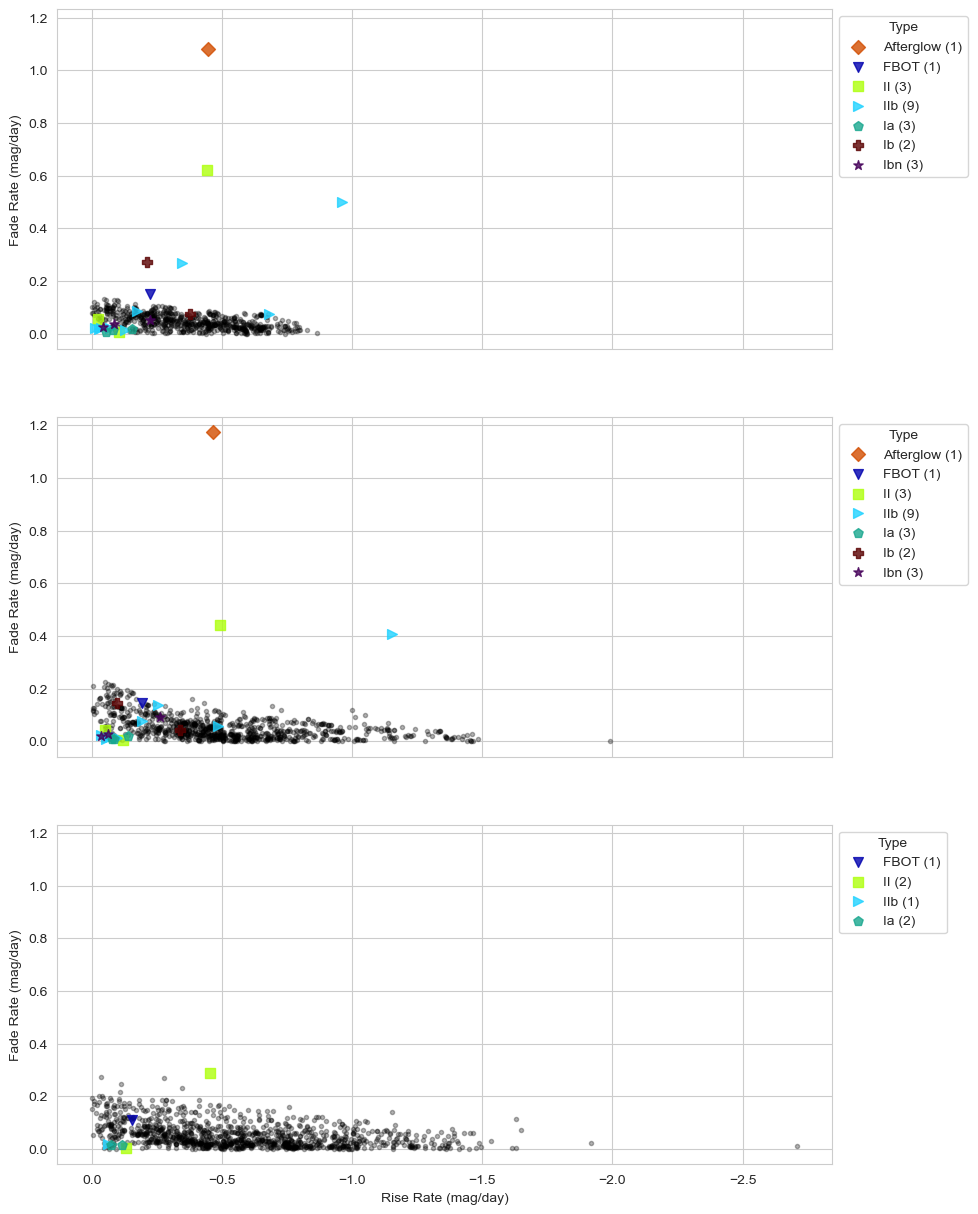

In [16]:
## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']
df_rates_far = df_rates[df_rates['redshift'] > 0.001]
## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates_far
fig, axs = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True , sharey=True)
# ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    axs[axi].scatter(df_2019[f'{filter}_rise_rate'], df_2019[f'{filter}_fade_rate'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates_far['type'].unique():
        df_class = df_rates_far[(df_rates_far['type'] == type_) & (df_rates_far[f'{filter}_fade_rate'].notnull()) & (df_rates_far[f'{filter}_rise_rate'].notnull())]
        if len(df_class) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            axs[axi].scatter(df_class[f'{filter}_rise_rate'], df_class[f'{filter}_fade_rate'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
    
    #sns.scatterplot(data=df_2019, x=f'{filter}_rise_rate', y=f'{filter}_fade_rate', ax=ax[axi],alpha=0.5)
    #sns.scatterplot(data=df_rates_far, x=f'{filter}_rise_rate', y=f'{filter}_fade_rate', hue='type', style='type', s=150, ax=ax[axi])

#ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
#ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates[(df_rates['ztfg_rise_rate'].notnull()) & (df_rates['ztfg_fade_rate'].notnull())]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[(df_rates['ztfr_rise_rate'].notnull()) & (df_rates['ztfr_fade_rate'].notnull())]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[(df_rates['ztfi_rise_rate'].notnull()) & (df_rates['ztfi_fade_rate'].notnull())]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(axs, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
axs[0].set_ylabel("Fade Rate (mag/day)"), axs[1].set_ylabel("Fade Rate (mag/day)"), axs[2].set_ylabel("Fade Rate (mag/day)")
axs[0].set_xlabel(""), axs[0].set_xlabel(""), axs[2].set_xlabel("Rise Rate (mag/day)");
axs[0].invert_xaxis(), axs[1].invert_xaxis(), axs[2].invert_xaxis();
plt.savefig(f'figures/rise_rate_vs_fade_rate{ext}', bbox_inches='tight') if savefigs else None
plt.show()

g-band rise vs r-band rise & g-band fade vs r-band fade

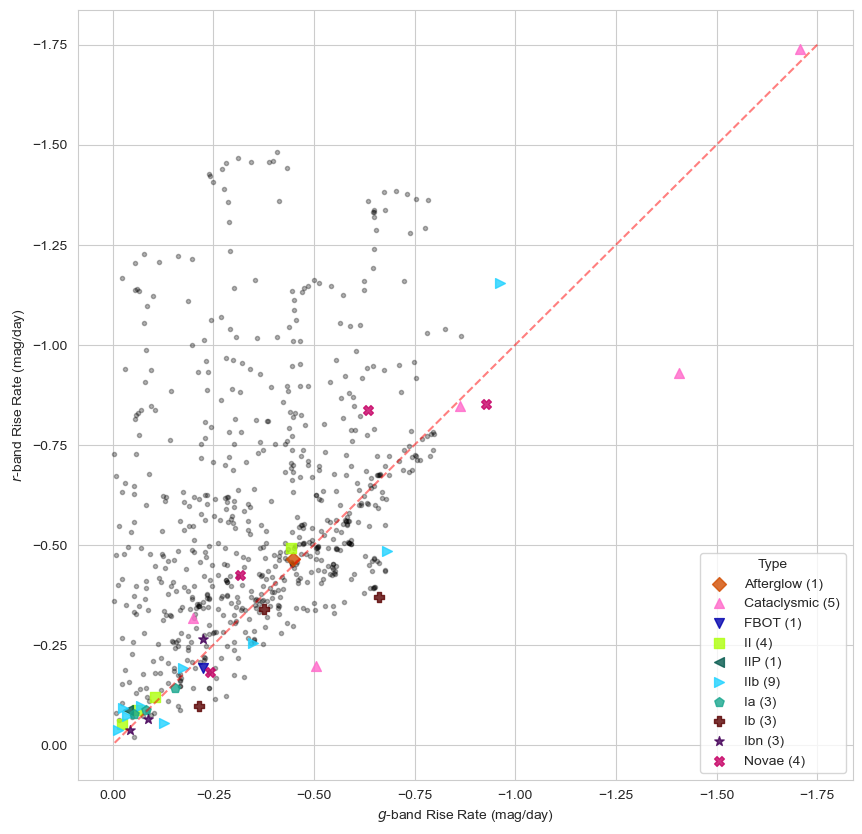

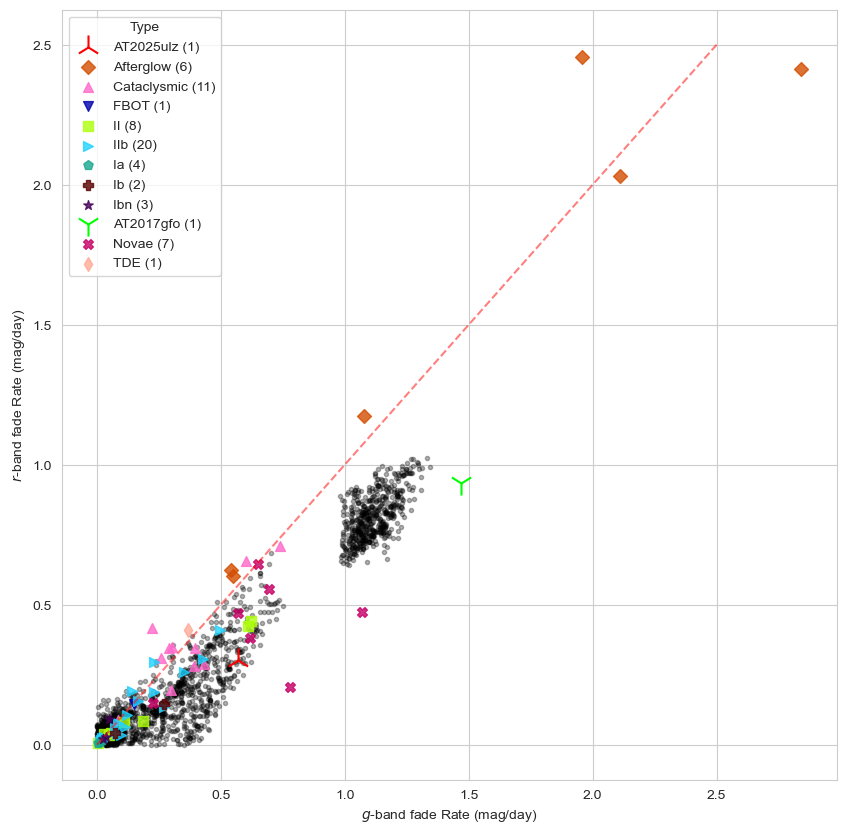

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10), 
                       sharex=True,sharey=True)
# ax.grid()
axs.scatter(df_2019[df_2019[f'ztfr_rise_rate'] > -1.75][f'ztfg_rise_rate'], df_2019[df_2019[f'ztfr_rise_rate'] > -1.75][f'ztfr_rise_rate'], alpha=0.3,color='k',marker='.')
axs.plot(np.linspace(-1.75,0,100), np.linspace(-1.75,0,100), color='r', linestyle='--',alpha=0.5)
for type_ in df_rates['type'].unique():
    df_class = df_rates[(df_rates['type'] == type_) & (df_rates['ztfg_rise_rate'].notnull()) & (df_rates['ztfr_rise_rate'].notnull())]
    if len(df_class) > 0:
        s_ = type_style_dict[type_]['size']
        a_ = type_style_dict[type_]['alpha']
        c_ = type_style_dict[type_]['color']
        m_ = type_style_dict[type_]['marker']
        z_ = type_style_dict[type_]['zorder']
        axs.scatter(df_class[f'ztfg_rise_rate'], df_class[f'ztfr_rise_rate'],
                        color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker'],
                            s=s_, alpha=a_, label=type_, zorder=z_)

class_counts_ztfg_ztfr = df_rates[(df_rates['ztfg_rise_rate'].notnull()) & (df_rates['ztfr_rise_rate'].notnull())]['type'].value_counts().to_dict()
handles, labels = axs.get_legend_handles_labels()
new_labels = [f'{label} ({class_counts_ztfg_ztfr[label]})' for label in labels if label in class_counts_ztfg_ztfr]
legend = axs.legend(handles, new_labels, title='Type')#, bbox_to_anchor=(1, 1), loc="upper left")
axs.set_ylabel("$\it{r}$-band Rise Rate (mag/day)"), axs.set_xlabel("$\it{g}$-band Rise Rate (mag/day)");
#plt.savefig(f'figures/ztfg_rise_rate_vs_ztfr_rise_rate{ext}', bbox_inches='tight')
axs.invert_xaxis(), axs.invert_yaxis()
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(10, 10), 
                       sharex=True,sharey=True)
# ax.grid()
axs.scatter(df_2019[df_2019[f'ztfr_fade_rate'] > -1.75][f'ztfg_fade_rate'], df_2019[df_2019[f'ztfr_fade_rate'] > -1.75][f'ztfr_fade_rate'], alpha=0.3,color='k',marker='.')
axs.plot(np.linspace(0,2.5,100), np.linspace(0,2.5,100), color='r', linestyle='--',alpha=0.5)
for type_ in df_rates['type'].unique():
    df_class = df_rates[(df_rates['type'] == type_) & (df_rates['ztfg_fade_rate'].notnull()) & (df_rates['ztfr_fade_rate'].notnull())]
    if len(df_class) > 0:
        s_ = type_style_dict[type_]['size']
        a_ = type_style_dict[type_]['alpha']
        c_ = type_style_dict[type_]['color']
        m_ = type_style_dict[type_]['marker']
        z_ = type_style_dict[type_]['zorder']
        axs.scatter(df_class[f'ztfg_fade_rate'], df_class[f'ztfr_fade_rate'],
                        color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)

class_counts_ztfg_ztfr = df_rates[(df_rates['ztfg_fade_rate'].notnull()) & (df_rates['ztfr_fade_rate'].notnull())]['type'].value_counts().to_dict()
handles, labels = axs.get_legend_handles_labels()
new_labels = [f'{label} ({class_counts_ztfg_ztfr[label]})' for label in labels if label in class_counts_ztfg_ztfr]
legend = axs.legend(handles, new_labels, title='Type')#, bbox_to_anchor=(1, 1), loc="upper left")
#ax.invert_xaxis(), ax.invert_yaxis()

axs.set_ylabel("$\it{r}$-band fade Rate (mag/day)"), axs.set_xlabel("$\it{g}$-band fade Rate (mag/day)");
plt.savefig(f'figures/ztfg_fade_rate_vs_ztfr_fade_rate{ext}', bbox_inches='tight') if savefigs else None

plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

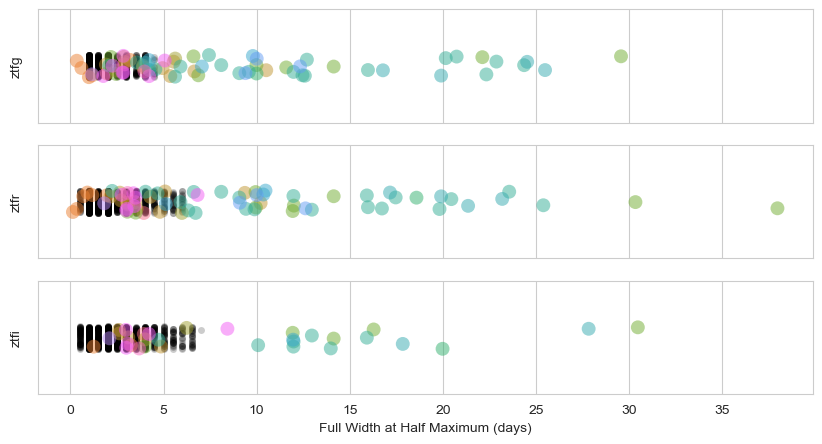

In [18]:
## stripplot of the rise rate for each filter including the kilonova model
fig, axs = plt.subplots(3, 1, figsize=(10, 5), 
                       sharex=True,sharey=True)
for axi, filter in enumerate(filters):
    sns.stripplot(data=df_2019, x=f'{filter}_fwhm', ax=axs[axi], alpha=0.2, color='k')
    sns.stripplot(data=df_rates, x=f'{filter}_fwhm', ax=axs[axi], alpha=0.5, hue='type', s=10, legend=False)
    axs[axi].set_ylabel(f"{filter}")
    axs[axi].set_xlabel("Full Width at Half Maximum (days)")
    # ax[axi].invert_xaxis()
    # ax[axi].invert_yaxis()
    # ax[axi].set_xlim(0.1,-2)

## Metric Distances Experiment

In [19]:
# def metric_distance_2d(object, model_data):
#     '''
#     Finds the average distance between an object and model data. 
    
#     Args:
#     object (tuple): tuple containing an object's two metrics (x,y)
#     model_data (list): list of tuples containing the model data's metrics (x,y)
    
#     Returns:
#     distance (float): average distance between object and model_data
#     '''
#     distance_array = np.array([np.sqrt((object[0] - model[0])**2 + (object[1] - model[1])**2) for model in model_data])
#     distance_array = distance_array[~np.isnan(distance_array)]
#     # print(distance_array)
#     distance = np.mean(distance_array)
#     return distance

def metric_distance(object, model_data, raw=False):
    '''
    Finds the average distance between the object and model data in n-dimensional space.
    
    Args:
    object (tuple): tuple containing an object's metrics
    model_data (list): list of tuples containing the model data's metrics
    raw (bool): if True, returns the raw distance array
    
    Returns:
    distance (float): average distance between object and model_data
    '''
    # print(object)
    # print(model_data)
    # print(type(object))
    # print(type(model_data))
    if type(object) != np.ndarray:
        object = np.array([object])
    if type(model_data) != np.ndarray:
        model_data = np.array([model_data])
    # if len(object) != len(model_data[0]):
    #     raise ValueError('The object and model data must have the same number of dimensions')
    if len(object) == 1:
        distance_array = np.abs(object - model_data) 
    else:
        distance_array = np.sqrt(np.sum((object - model_data)**2, axis=1))
    
    #distance_array = distance_array[~np.isnan(distance_array)]
    distance = np.mean(distance_array) if not raw else distance_array
    return distance


In [20]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [21]:
display(df_rates)
display(df_2019)

,obj_id,type,category,redshift,ztfg_peak_time,ztfg_peak_mag,ztfr_peak_time,ztfr_peak_mag,ztfi_peak_time,ztfi_peak_mag,...,ztfr_rise_duration,ztfr_rise_rate,ztfi_rise_duration,ztfi_rise_rate,ztfg_fade_duration,ztfg_fade_rate,ztfr_fade_duration,ztfr_fade_rate,ztfi_fade_duration,ztfi_fade_rate
69,ZTF25abjmnps,AT2025ulz,AT2025ulz,0.08480,0.000000,-16.848637,0.000000,-16.710861,0.000000,-16.512919,...,NaN,NaN,NaN,NaN,1.968732,0.569050,1.968732,0.302362,1.968732,0.061935
27,ZTF20acozryr,Afterglow,Afterglow,1.10500,0.000000,-24.982499,0.000000,-25.159879,NaN,NaN,...,NaN,NaN,NaN,NaN,0.976551,0.541711,0.976551,0.622483,NaN,NaN
38,ZTF21abfmpwn,Afterglow,Afterglow,1.13450,0.000000,-25.995617,0.000000,-26.251762,NaN,NaN,...,NaN,NaN,NaN,NaN,1.101111,2.108729,1.101111,2.029503,NaN,NaN
41,ZTF22aabjpxh,Afterglow,Afterglow,0.29300,0.000000,-24.202251,0.000000,-24.375539,0.000000,-24.383250,...,NaN,NaN,NaN,NaN,1.010741,2.842063,1.010741,2.411686,1.010741,1.944579
57,ZTF23aaoohpy,Afterglow,Afterglow,1.02700,0.244034,-24.708486,0.181406,-24.958452,NaN,NaN,...,0.181406,-0.464425,NaN,NaN,0.834682,1.079221,0.897310,1.172814,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,ZTF20acgigfo,Novae,Galactic,0.00017,3.304714,-6.844664,3.121119,-7.332601,NaN,NaN,...,3.121119,-0.425147,NaN,NaN,1.973649,0.648745,1.973649,0.646859,NaN,NaN
49,ZTF22abijszk,Novae,Galactic,0.00100,0.000000,-8.016094,0.000000,-9.144732,NaN,NaN,...,NaN,NaN,NaN,NaN,1.934028,1.067826,1.934028,0.475787,NaN,NaN
48,ZTF22abfxmpc,Novae,Galactic,0.00000,0.793516,2.836526,0.793516,2.802224,1.058021,2.873734,...,0.793516,-0.183027,1.058021,-0.128745,1.983790,0.778070,1.983790,0.206140,1.939705,0.056325
46,ZTF22aazmooy,Novae,Galactic,0.00017,1.462144,-6.973774,1.305485,-7.384998,1.357705,-7.431442,...,1.305485,-0.837569,1.357705,-0.821712,1.984338,0.568944,1.984338,0.469871,1.984338,0.406810


,ztfg_peak_mag,ztfg_peak_time,ztfg_rise_rate,ztfg_fade_rate,ztfg_fwhm,ztfg_rise_hwhm,ztfg_fade_hwhm,ztfr_peak_mag,ztfr_peak_time,ztfr_rise_rate,...,ztfi_rise_hwhm,ztfi_fade_hwhm,ztfg_peak_gr_color,ztfg_peak_gi_color,ztfr_peak_gr_color,ztfr_peak_ri_color,ztfi_peak_gi_color,ztfi_peak_ri_color,model,obj_id
0,-14.803,0.5,NaN,1.182000,NaN,NaN,NaN,-15.659,0.5,NaN,...,NaN,NaN,0.856,0.903,0.856,0.047,0.903,0.047,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta0.00_dMpc0
1,-14.730,0.5,NaN,1.165333,NaN,NaN,NaN,-15.582,0.5,NaN,...,NaN,NaN,0.852,0.903,0.852,0.051,0.903,0.051,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta25.84_d...
2,-14.655,0.5,NaN,1.149333,NaN,NaN,NaN,-15.505,0.5,NaN,...,NaN,NaN,0.850,0.910,0.850,0.060,0.910,0.060,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta36.87_d...
3,-14.578,0.5,NaN,1.130000,NaN,NaN,NaN,-15.429,0.5,NaN,...,NaN,NaN,0.851,0.913,0.851,0.062,0.913,0.062,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta45.57_d...
4,-14.501,0.5,NaN,1.108000,NaN,NaN,NaN,-15.355,0.5,NaN,...,NaN,NaN,0.854,0.916,0.854,0.062,0.916,0.062,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta53.13_d...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,-13.058,2.5,-0.7430,0.028000,4.5,1.0,3.5,-13.853,3.0,-0.7204,...,1.5,5.0,0.762,1.264,0.837,0.512,1.380,0.526,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta66.42_d...
2196,-13.039,2.5,-0.7495,0.016667,4.5,1.0,3.5,-13.845,3.0,-0.7248,...,1.5,5.0,0.771,1.273,0.831,0.515,1.389,0.537,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta72.54_d...
2197,-13.029,2.5,-0.7520,0.010667,4.5,1.0,3.5,-13.841,3.0,-0.7208,...,1.5,5.0,0.779,1.278,0.828,0.514,1.386,0.534,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta78.46_d...
2198,-13.029,2.5,-0.7565,0.014000,4.5,1.0,3.5,-13.841,3.0,-0.7120,...,1.5,5.0,0.776,1.277,0.833,0.513,1.384,0.530,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta84.26_d...


In [22]:
def calc_radar_data(df_objects, df_grid, grouping='type', metrics='all'):
    '''
    Calculates the average distance between each object type and the model data for each metric. The average for each metric is calculated by taking the average of the distance to all points in the model data to all objects in a given object type to prevent taking an average of an average.
    
    Args:
    df_objects (pd.DataFrame): DataFrame containing the object metrics
    df_grid (pd.DataFrame): DataFrame containing the model data
    metrics (list): list of metrics to calculate the distance for. If 'all', calculates the distance for all metrics
    
    Returns:
    radar_data (pd.DataFrame): DataFrame containing the average distance between each object type and the model data for each metric. Each row corresponds to a different object type and each column corresponds to a different metric. If a given object type does not have measurements in that metric, that index is NaN.
    '''
    
    types_ = df_objects[grouping].unique().tolist()
    metrics_ = df_grid.columns.tolist()[:-2] if metrics == 'all' else metrics
    
    df_radar_data = pd.DataFrame(index=types_, columns=metrics_)
    for type_ in types_:
        df_type = df_objects[df_objects[grouping] == type_]
        for metric in metrics_:
            df_type_metric = np.array(df_type[metric].dropna().tolist())
            df_grid_metric = np.array(df_grid[metric].dropna().tolist())
            if len(df_type_metric) == 0:
                df_radar_data.loc[type_, metric] = 0
                continue
            else:
                radar_data = [metric_distance(obj_, df_grid_metric, raw=True) for obj_ in df_type_metric]
                radar_data = np.mean(radar_data)
                df_radar_data.loc[type_, metric] = radar_data
            
    return df_radar_data

In [23]:
def format_radar_data(df_radar_data):
    '''
    Formats the radar data for plotting
    
    Args:
    df_radar_data (pd.DataFrame): DataFrame containing the average distance between each object type and the model data for each metric. Each row corresponds to a different object type and each column corresponds to a different metric. If a given object type does not have measurements in that metric, that index is NaN.
    
    Returns:
    radar_data (array): an array formatted for the radar plot. The structure is as follows:
    - first index in the array is an array with the object types, which is the index of the input DataFrame
    - subsequent indices are lists that each correspond to a different metrics. Each list is structured in the general format ('metric_name',[[x,x,x,x,x]])
    '''
    radar_data = []
    radar_data.append(df_radar_data.index.tolist())
    for metric in df_radar_data.columns:
        radar_data.append((metric, [df_radar_data[metric].tolist()]))
    return radar_data


In [24]:
df_2019.columns

Index(['ztfg_peak_mag', 'ztfg_peak_time', 'ztfg_rise_rate', 'ztfg_fade_rate',
       'ztfg_fwhm', 'ztfg_rise_hwhm', 'ztfg_fade_hwhm', 'ztfr_peak_mag',
       'ztfr_peak_time', 'ztfr_rise_rate', 'ztfr_fade_rate', 'ztfr_fwhm',
       'ztfr_rise_hwhm', 'ztfr_fade_hwhm', 'ztfi_peak_mag', 'ztfi_peak_time',
       'ztfi_rise_rate', 'ztfi_fade_rate', 'ztfi_fwhm', 'ztfi_rise_hwhm',
       'ztfi_fade_hwhm', 'ztfg_peak_gr_color', 'ztfg_peak_gi_color',
       'ztfr_peak_gr_color', 'ztfr_peak_ri_color', 'ztfi_peak_gi_color',
       'ztfi_peak_ri_color', 'model', 'obj_id'],
      dtype='object')

In [25]:
radar_metrics_ = [
'ztfg_peak_mag',
'ztfr_peak_mag',
'ztfi_peak_mag',
'ztfg_rise_rate',
'ztfr_rise_rate',
'ztfi_rise_rate',
'ztfg_fade_rate',
'ztfr_fade_rate',
'ztfi_fade_rate',
'ztfg_fwhm',
'ztfr_fwhm',
'ztfi_fwhm',
'ztfg_peak_gr_color',
'ztfg_peak_gi_color',
'ztfr_peak_gr_color',
'ztfr_peak_ri_color',
'ztfi_peak_gi_color',
'ztfi_peak_ri_color',
]

radar_metrics_labels_ = {
'ztfg_peak_mag': 'g-band Peak M$_{abs}$',
'ztfr_peak_mag': 'r-band Peak M$_{abs}$',
'ztfi_peak_mag': 'i-band Peak M$_{abs}$',
'ztfg_rise_rate': 'g-band Rise Rate',
'ztfr_rise_rate': 'r-band Rise Rate',
'ztfi_rise_rate': 'i-band Rise Rate',
'ztfg_fade_rate': 'g-band Fade Rate',
'ztfr_fade_rate': 'r-band Fade Rate',
'ztfi_fade_rate': 'i-band Fade Rate',
'ztfg_fwhm': 'g-band FWHM',
'ztfr_fwhm': 'r-band FWHM',
'ztfi_fwhm': 'i-band FWHM',
'ztfg_peak_gr_color': 'g-band Peak g-r Color',
'ztfg_peak_gi_color': 'g-band Peak g-i Color',
'ztfr_peak_gr_color': 'r-band Peak g-r Color',
'ztfr_peak_ri_color': 'r-band Peak r-i Color',
'ztfi_peak_gi_color': 'i-band Peak g-i Color',
'ztfi_peak_ri_color': 'i-band Peak r-i Color',
}

In [26]:
# def gen_radar_data(df_objects, df_grid, metrics='all'):
#     '''
#     Generates the radar data for each object in df_objects using the metrics in metrics.
    
#     Args:
#     df_objects (pd.DataFrame): dataframe containing the objects
#     df_grid (pd.DataFrame): dataframe containing the grid data
#     metrics (list): list of metrics to use. If 'all', all metrics will be calculated
    
#     Returns:
#     radar_data (list): list of radar data for each object
#     '''
#     types_ = df_objects['type'].unique().tolist()
#     radar_data = [types_]
#     if metrics == 'all' or metrics == ['all']:
#         metrics = df_objects.columns.tolist()[3:]
#         metrics = np.array([metric for metric in metrics if metric in df_grid.columns]).tolist()
#         metrics = np.array([metric for metric in metrics if metric not in ['obj_id', 'type', 'redshift','model', 'ztfg_peak_time', 'ztfr_peak_time', 'ztfi_peak_time']]).tolist()
    
#     metric_data = []
#     objects_np = df_objects[metrics].values
#     ##print(objects_np)
#     grid_np = df_grid[metrics].values 
#     for metric_idx, metric in enumerate(metrics):
#         ind_metric_data = np.zeros(len(types_))  # Pre-allocate array
#         for type_idx, type_ in enumerate(types_):
#             #print('\n',type_)
#             df_type = df_objects[df_objects['type'] == type_]
#             df_type_idx = df_type.index
#             #print('type idx ',df_type_idx)
#             type_distance = []#np.zeros(len(df_type),dtype=object)
#             for obj_idx in df_type.index:
#                 #print('obj idx ',obj_idx)
#                 object_ = [objects_np[obj_idx][metric_idx]]
#                 #print('object ',object_)
                
#                 grid_params = [value for value in grid_np[:,metric_idx]]
#                 #print('grid params ',grid_params)
#                 ##print(metric_distance(object_, grid_params, raw=True))
#                 # type_distance[i] = np.array(metric_distance(object_, grid_params, raw=True) )
#                 type_distance.append(metric_distance(object_, grid_params, raw=True))
#                 # #print(type_)
#                 #print('type_distance ',type_distance)
                
#             if len(type_distance) == 1:
#                 # #print(type_)
#                 # #print(type_distance)
#                 # mean_distance = np.mean(np.concatenate(type_distance).ravel())
#                 #print(np.concatenate(type_distance))
#                 mean_distance = np.mean(np.concatenate(type_distance))
#                 #return
#                 # #print(mean_distance)
#             else:
#                 # #print('more than one ', type_)
#                 # #print(np.concatenate(type_distance).ravel())
#                 #print(np.concatenate(type_distance))
#                 mean_distance = np.mean(np.concatenate(type_distance))
#                 # mean_distance = np.mean(np.concatenate(type_distance).ravel())
#                 # #print(metric)
#                 # #print(type_)
#                 # #print(type_distance[0])
                
#                 # #print(mean_distance)
#                 # #print()
#             #mean_distance = np.nanmean(type_distance) if len(type_distance) > 1 else type_distance[0]
#             ind_metric_data[type_idx] = mean_distance if not np.isnan(mean_distance) else 0
#             #ind_metric_data[type_idx] = np.nanmean(type_distance)
#             #ind_metric_data.append(np.nanmean(type_distance))
#         metric_data.append(ind_metric_data.tolist())
        
    
            
#     # for metric in metrics:
#     #     ind_metric_data = []
#     #     for type_ in types_:
#     #         ##print(type_)
#     #         df_type = df_objects[df_objects['type'] == type_]
#     #         type_distance = []
#     #         for index, row in df_type.iterrows():
#     #             object = [row[metric] for metric in metrics]
#     #             model_data = [[row[metric] for metric in metrics] for index, row in df_grid.iterrows()]
#     #             type_distance.append(metric_distance(object, model_data, raw=True))
#     #         type_distance = np.concatenate(type_distance).ravel()
#     #         type_distance = np.nanmean(type_distance) ## esnures that the distance is an average of all the distances rather than avg of avg
#     #         type_distance = 0 if np.isnan(type_distance) else type_distance
#     #         ind_metric_data.append(type_distance)
#     #     metric_data.append(ind_metric_data)  
    
    
#     for idx, metric in enumerate(metrics):
#         radar_data.append((metric, [metric_data[idx]]))

#     return radar_data

In [27]:
df_radar_rates = df_rates.copy()
df_grid_subsample = df_2019.sample(n=100, random_state=42)
df_grid_subsample['type'] = 'KN Model'
df_grid_subsample['category'] = 'KN Model'
df_radar_rates = pd.concat([df_radar_rates, df_grid_subsample], axis=0)
# df_radar_rates

In [28]:
df_radar_rates

,obj_id,type,category,redshift,ztfg_peak_time,ztfg_peak_mag,ztfr_peak_time,ztfr_peak_mag,ztfi_peak_time,ztfi_peak_mag,...,ztfr_rise_rate,ztfi_rise_duration,ztfi_rise_rate,ztfg_fade_duration,ztfg_fade_rate,ztfr_fade_duration,ztfr_fade_rate,ztfi_fade_duration,ztfi_fade_rate,model
69,ZTF25abjmnps,AT2025ulz,AT2025ulz,0.0848,0.000000,-16.848637,0.000000,-16.710861,0.0,-16.512919,...,NaN,NaN,NaN,1.968732,0.569050,1.968732,0.302362,1.968732,0.061935,NaN
27,ZTF20acozryr,Afterglow,Afterglow,1.1050,0.000000,-24.982499,0.000000,-25.159879,NaN,NaN,...,NaN,NaN,NaN,0.976551,0.541711,0.976551,0.622483,NaN,NaN,NaN
38,ZTF21abfmpwn,Afterglow,Afterglow,1.1345,0.000000,-25.995617,0.000000,-26.251762,NaN,NaN,...,NaN,NaN,NaN,1.101111,2.108729,1.101111,2.029503,NaN,NaN,NaN
41,ZTF22aabjpxh,Afterglow,Afterglow,0.2930,0.000000,-24.202251,0.000000,-24.375539,0.0,-24.383250,...,NaN,NaN,NaN,1.010741,2.842063,1.010741,2.411686,1.010741,1.944579,NaN
57,ZTF23aaoohpy,Afterglow,Afterglow,1.0270,0.244034,-24.708486,0.181406,-24.958452,NaN,NaN,...,-0.464425,NaN,NaN,0.834682,1.079221,0.897310,1.172814,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,nph1.0e+06_mej0.03_phi60_T3.0e+03_theta84.26_d...,KN Model,KN Model,NaN,0.500000,-13.319000,0.500000,-14.467000,0.5,-15.241000,...,NaN,NaN,NaN,NaN,1.198000,NaN,0.855333,NaN,0.713333,bulla_2019
350,nph1.0e+06_mej0.02_phi45_T9.0e+03_theta84.26_d...,KN Model,KN Model,NaN,1.500000,-12.772000,1.000000,-13.379000,1.0,-13.771000,...,-0.344000,NaN,-0.188,NaN,0.105333,NaN,0.023333,NaN,0.055333,bulla_2019
2131,nph1.0e+06_mej0.10_phi60_T5.0e+03_theta78.46_d...,KN Model,KN Model,NaN,0.500000,-13.136000,1.000000,-13.884000,1.5,-14.578000,...,-0.068000,NaN,-0.278,NaN,0.124000,NaN,0.007333,NaN,0.061333,bulla_2019
719,nph1.0e+06_mej0.04_phi30_T5.0e+03_theta53.13_d...,KN Model,KN Model,NaN,0.500000,-14.918000,0.500000,-15.500000,0.5,-15.451000,...,NaN,NaN,NaN,NaN,0.509333,NaN,0.235333,NaN,0.058667,bulla_2019


In [29]:
radar_data = format_radar_data(calc_radar_data(df_radar_rates, df_2019, grouping='category', metrics=radar_metrics_))
radar_peak = format_radar_data(calc_radar_data(df_radar_rates, df_2019, grouping='category', metrics=['ztfg_peak_mag', 'ztfr_peak_mag', 'ztfi_peak_mag']))
radar_rise = format_radar_data(calc_radar_data(df_radar_rates, df_2019, grouping='category', metrics=['ztfg_rise_rate', 'ztfr_rise_rate', 'ztfi_rise_rate']))
radar_fade = format_radar_data(calc_radar_data(df_radar_rates, df_2019, grouping='category', metrics=['ztfg_fade_rate', 'ztfr_fade_rate', 'ztfi_fade_rate']))
radar_fwhm = format_radar_data(calc_radar_data(df_radar_rates, df_2019, grouping='category', metrics=['ztfg_fwhm', 'ztfr_fwhm', 'ztfi_fwhm']))
radar_color = format_radar_data(calc_radar_data(df_radar_rates, df_2019, grouping='category', metrics=['ztfg_peak_gr_color', 'ztfg_peak_gi_color', 'ztfr_peak_gr_color', 'ztfr_peak_ri_color', 'ztfi_peak_gi_color', 'ztfi_peak_ri_color']))

In [30]:
N = len(radar_data[0])

theta = radar_factory(N, frame='polygon')

#data = example_data()
spoke_labels = radar_data[0]
data = radar_data[1:]
print(np.shape(radar_data))

fig, axs = plt.subplots(figsize=(15, 7*int(np.shape(radar_data)[0]/3)), nrows=int(np.shape(radar_data)[0]/3), ncols=3,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.3, hspace=0.20, top=0.6, bottom=0.05)

colors = ['b', 'r', 'g', 'm', 'y']
# Plot the four cases from the example data on separate Axes
for axs, (title, case_data) in zip(axs.flat, data):
    case_data_max = np.max(case_data)
    axs.set_rgrids([case_data_max/4, case_data_max/2, case_data_max*3/4])
    axs.set_title(radar_metrics_labels_[title], weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        axs.plot(theta, d, color=color)
        axs.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    axs.set_varlabels(spoke_labels)

# # add legend relative to top-left plot
# labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
# legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                             labelspacing=0.1, fontsize='small')

# fig.text(0.5, 0.965, 'Metric Distances',
#             horizontalalignment='center', color='black', weight='bold',
#             size='large')
fig.savefig(f'figures/radar_plot_all_spokes{ext}', bbox_inches='tight') if savefigs else None
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (19,) + inhomogeneous part.

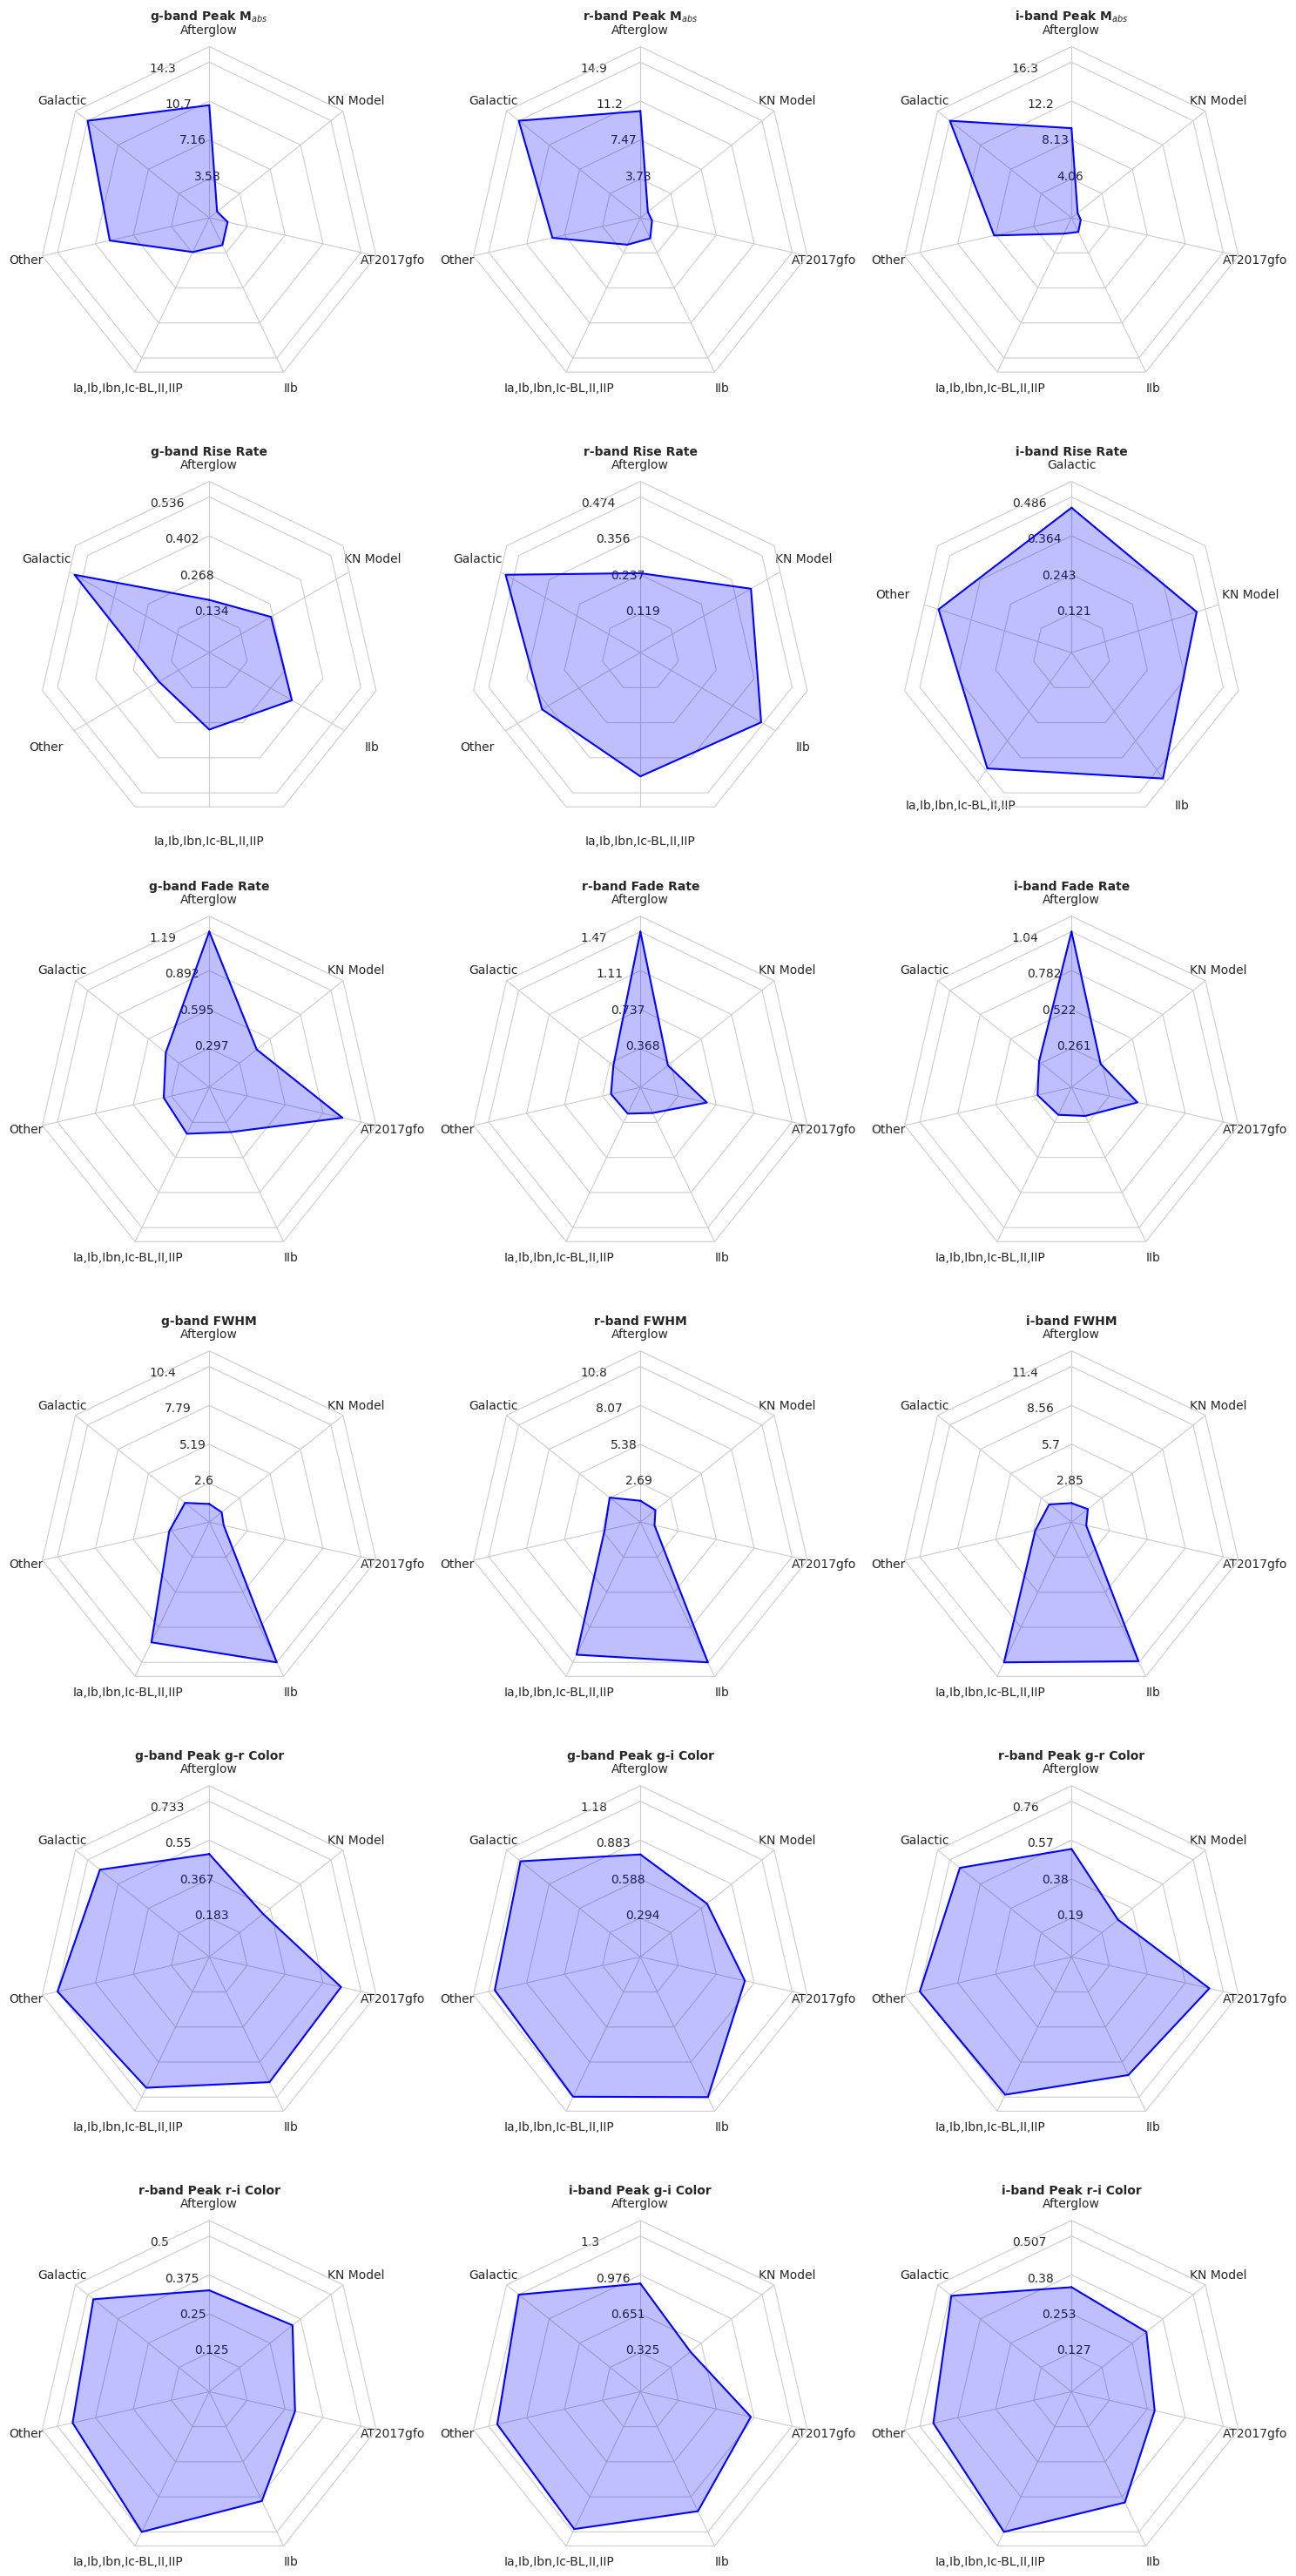

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Function to filter data and labels for a single subplot
def filter_data(case_data, spoke_labels):
    """Filters data and spoke labels based on non-zero values."""
    spoke_labels_filtered = [label for label, value in zip(spoke_labels, case_data[0]) if value != 0]
    case_data_filtered = [value for value in case_data[0] if value != 0]
    theta_filtered = np.linspace(0, 2 * np.pi, len(case_data_filtered), endpoint=False)
    return theta_filtered, case_data_filtered, spoke_labels_filtered

# Create the subplots
fig, axs = plt.subplots(nrows=int(np.ceil(len(radar_data[1:]) / 3)), ncols=3, 
                        figsize=(15, 5 * int(np.ceil(len(radar_data[1:]) / 3))), 
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.35, hspace=0.20, top=0.85, bottom=0.05)

# Get the spoke labels from the first row of radar_data
spoke_labels = radar_data[0]

# Plot the data on each subplot
for axs, (title, case_data) in zip(axs.flat, radar_data[1:]):

    # Filter data and labels for this subplot
    theta_filtered, case_data_filtered, spoke_labels_filtered = filter_data(case_data, spoke_labels)

    case_data_max = np.max(case_data_filtered)
    axs.set_rgrids([case_data_max/4, case_data_max/2, case_data_max*3/4,case_data_max]) ## this is resulting in some plots only having 2 grid lines instead of 4, fix it
    axs.set_ylim(0, case_data_max*1.1)
    axs.set_title(radar_metrics_labels_[title], weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    
    # Since you have only one color, you don't need the loop
    axs.plot(theta_filtered, case_data_filtered, color='b')
    axs.fill(theta_filtered, case_data_filtered, facecolor='b', alpha=0.25, label='_nolegend_')
    
    
    # Set the spoke labels and angles to match
    axs.set_thetagrids(np.degrees(theta_filtered), spoke_labels_filtered)
    axs.set_yticklabels([f"{i:.3g}" for i in axs.get_yticks()],zorder=np.inf)  # Hide radial axis labels


    
    

# Add title to the figure
# fig.text(0.5, 0.965, 'Metric Distances',
#          horizontalalignment='center', color='black', weight='bold',
#          size='large')

plt.tight_layout()

fig.savefig(f'figures/radar_plot{ext}', bbox_inches='tight') if savefigs else None
# plt.show()

TypeError: 'PolarAxes' object is not subscriptable

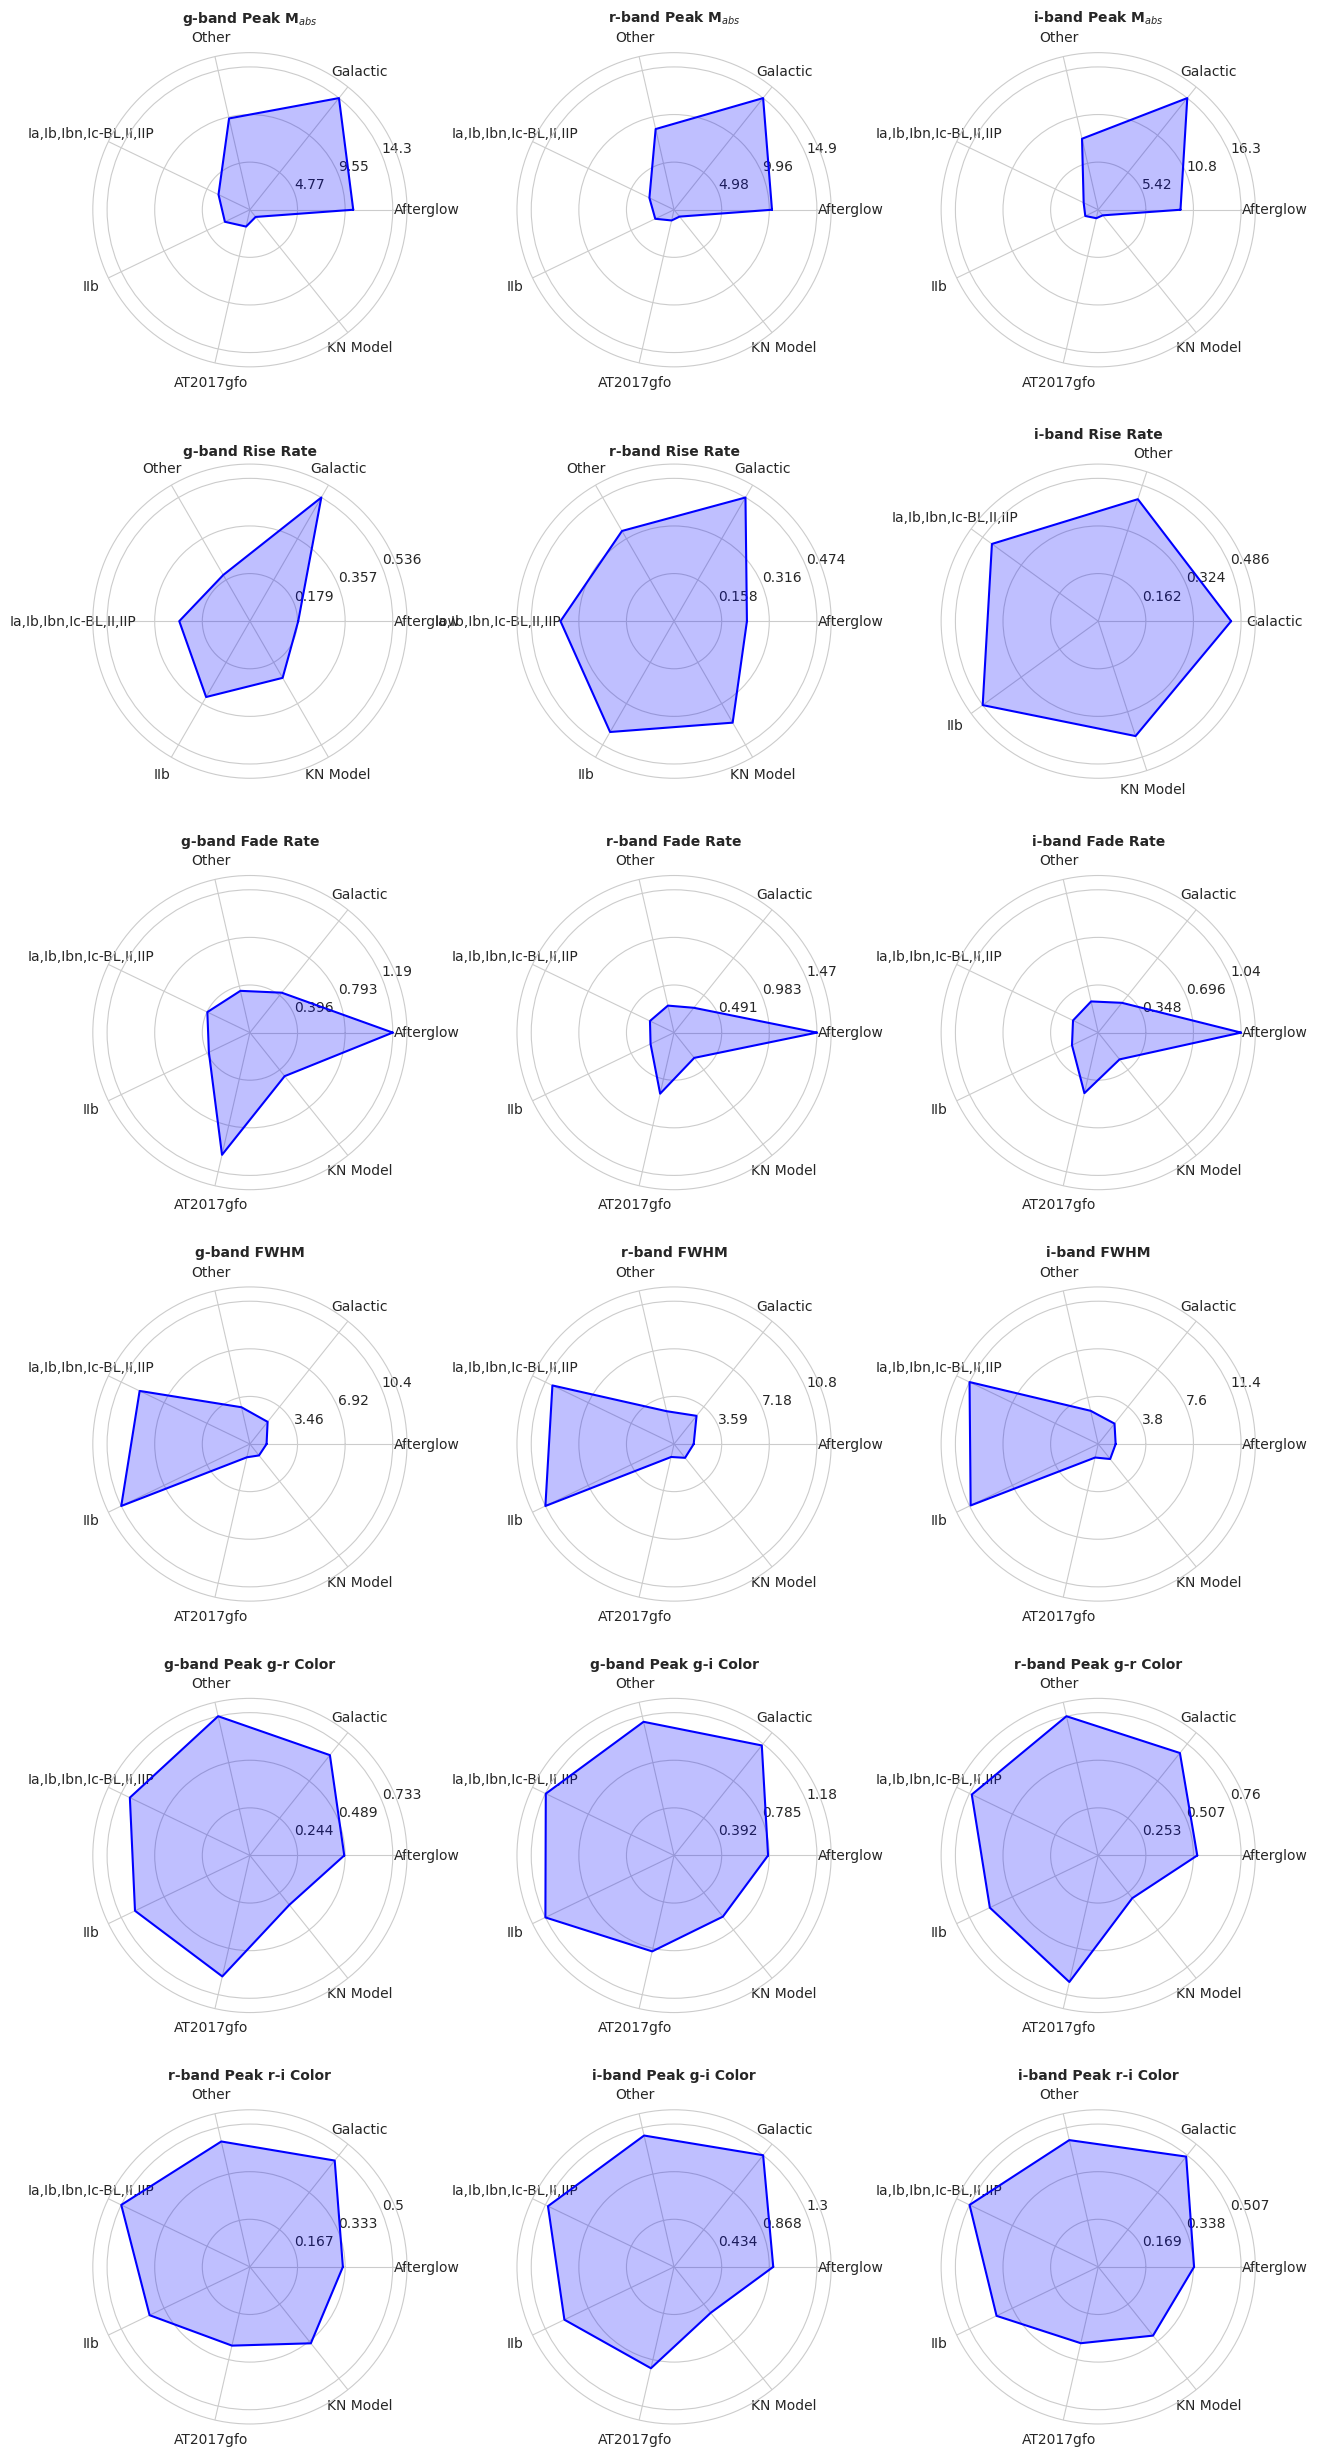

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def filter_data(case_data, spoke_labels):
    """Filter out zero values and corresponding labels"""
    values = case_data[0]
    filtered = [(val, label) for val, label in zip(values, spoke_labels) if val != 0]
    if not filtered:  # all values are zero
        return [], [], []
    case_data_filtered, spoke_labels_filtered = zip(*filtered)
    theta_filtered = np.linspace(0, 2 * np.pi, len(case_data_filtered), endpoint=False)
    return np.array(theta_filtered), np.array(case_data_filtered), spoke_labels_filtered

# Create subplots
nrows = int(np.ceil(len(radar_data[1:]) / 3))
fig, axs = plt.subplots(nrows=nrows, ncols=3,
                        figsize=(15, 5 * nrows),
                        subplot_kw=dict(polar=True))
fig.subplots_adjust(wspace=0.35, hspace=0.20, top=0.85, bottom=0.05)

# Ensure axs is a flat iterable even if there's only one row
axs = axs.flat if isinstance(axs, np.ndarray) else [axs]

# Spoke labels from first row
spoke_labels = radar_data[0]

for axs, (title, case_data) in zip(axs, radar_data[1:]):
    theta, values, labels = filter_data(case_data, spoke_labels)
    if len(theta) == 0:
        axs.set_visible(False)
        continue

    # Close the polygon
    theta = np.append(theta, theta[0])
    values = np.append(values, values[0])

    # Plot
    axs.plot(theta, values, color='b')
    axs.fill(theta, values, facecolor='b', alpha=0.25)

    # Ticks and labels
    axs.set_xticks(theta[:-1])
    axs.set_xticklabels(labels)

    # Set radius grid
    vmax = max(values)
    axs.set_rgrids(np.linspace(0, vmax, 4)[1:])
    axs.set_ylim(0, vmax * 1.1)

    # Title
    axs.set_title(radar_metrics_labels_[title], weight='bold', size='medium', position=(0.5, 1.1))

    # Optional: hide radial ticks if you'd like a cleaner plot
    axs.set_yticklabels([f"{i:.3g}" for i in axs.get_yticks()], zorder=np.inf)

# Hide any unused axes
for axs in axs[len(radar_data[1:]):]:
    axs.set_visible(False)

plt.tight_layout()
# fig.savefig(f'figures/radar_plot{ext}', bbox_inches='tight') if savefigs else None
# plt.show()


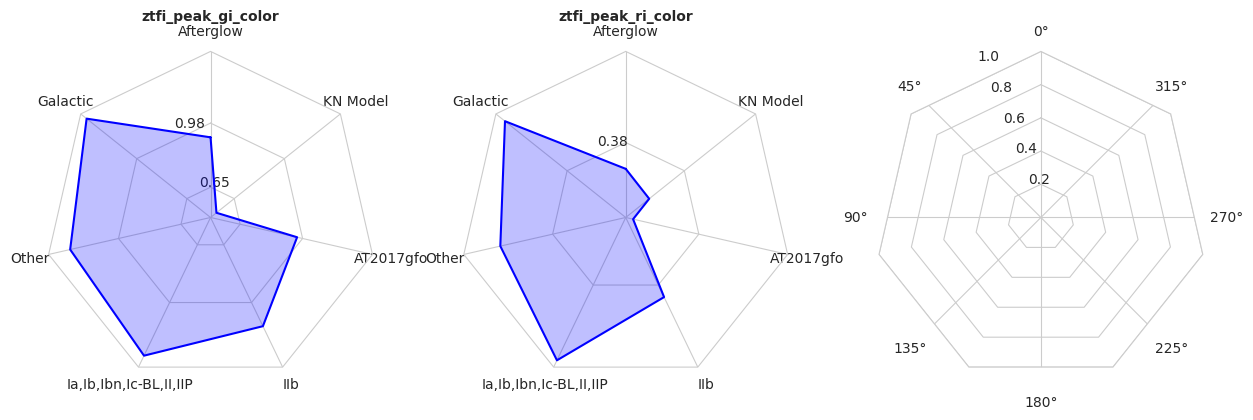

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## just the first value and then the 4,5,6 values
sub_radar_data = radar_data[:1] + radar_data[17:19]

# Function to filter data and labels for a single subplot
def filter_data(case_data, spoke_labels):
    """Filters data and spoke labels based on non-zero values."""
    spoke_labels_filtered = [label for label, value in zip(spoke_labels, case_data[0]) if value != 0]
    case_data_filtered = [value for value in case_data[0] if value != 0]
    theta_filtered = np.linspace(0, 2 * np.pi, len(case_data_filtered), endpoint=False)
    return theta_filtered, case_data_filtered, spoke_labels_filtered

# Create the subplots
fig, axs = plt.subplots(nrows=int(np.ceil(len(sub_radar_data[1:]) / 3)), ncols=3, 
                        figsize=(15, 5 * int(np.ceil(len(sub_radar_data[1:]) / 3))), 
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.95, bottom=0.05)

# Get the spoke labels from the first row of sub_radar_data
spoke_labels = sub_radar_data[0]

# Plot the data on each subplot
for axs, (title, case_data) in zip(axs.flat, sub_radar_data[1:]):

    # Filter data and labels for this subplot
    theta_filtered, case_data_filtered, spoke_labels_filtered = filter_data(case_data, spoke_labels)

    case_data_max = np.max(case_data_filtered)
    axs.set_rgrids([case_data_max/4, case_data_max/2, case_data_max*3/4])
    axs.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    
    # Since you have only one color, you don't need the loop
    axs.plot(theta_filtered, case_data_filtered, color='b')
    axs.fill(theta_filtered, case_data_filtered, facecolor='b', alpha=0.25, label='_nolegend_')
    
    # Set the spoke labels and angles to match
    axs.set_thetagrids(np.degrees(theta_filtered), spoke_labels_filtered)
    axs.set_yticklabels([f"{i:.2g}" for i in axs.get_yticks()])  # Hide radial axis labels

# plt.tight_layout()
plt.show()

In [ ]:
model_risepeak_list = list(zip(df_2019['ztfg_rise_rate'], df_2019['ztfg_peak_mag']))
objects_risepeak_list = list(zip(df_rates['ztfg_rise_rate'], df_rates['ztfg_peak_mag']))
# print(objects_risepeak_list)
# print(df_risepeak['obj_id'])
distance_risepeak = {obj: metric_distance(obj_data, model_risepeak_list) for obj, obj_data in zip(df_rates.obj_id, objects_risepeak_list)}

In [ ]:
for filt in ['ztfg', 'ztfr', 'ztfi']:
    model_risepeak_list = list(zip(df_2019[f'{filt}_rise_rate'], df_2019[f'{filt}_peak_mag']))
    objects_risepeak_list = list(zip(df_rates[f'{filt}_rise_rate'], df_rates[f'{filt}_peak_mag']))
    distance_risepeak = {obj: metric_distance(obj_data, model_risepeak_list) for obj, obj_data in zip(df_rates.obj_id, objects_risepeak_list)}
    df_rates[f'{filt}_risepeak_distance'] = distance_risepeak.values() 
    
    model_fadepeak_list = list(zip(df_2019[f'{filt}_fade_rate'], df_2019[f'{filt}_peak_mag']))
    objects_fadepeak_list = list(zip(df_rates[f'{filt}_fade_rate'], df_rates[f'{filt}_peak_mag']))
    distance_fadepeak = {obj: metric_distance(obj_data, model_fadepeak_list) for obj, obj_data in zip(df_rates.obj_id, objects_fadepeak_list)}
    df_rates[f'{filt}_fadepeak_distance'] = distance_fadepeak.values()

<Axes: xlabel='ztfg_fadepeak_distance', ylabel='Count'>

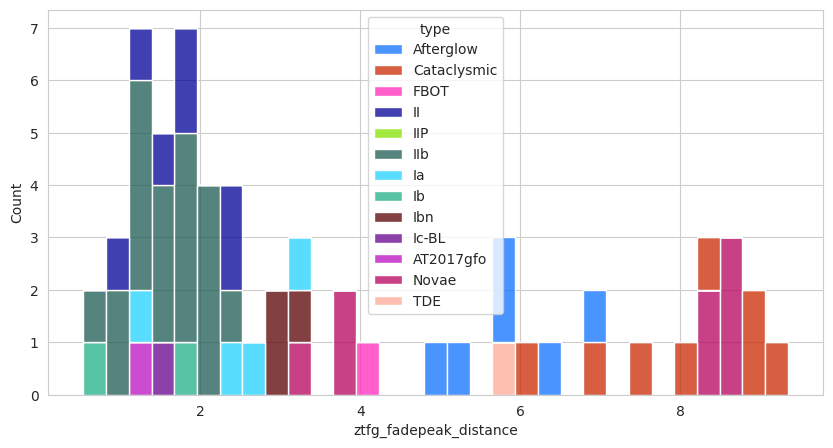

In [ ]:
sns.set_palette('colorblind')
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(data=df_rates, x='ztfg_fadepeak_distance', hue='type', palette=colors_dict, multiple='stack', ax=axs, bins=31)

((-0.01, 0.25), (-0.05, 35.0))

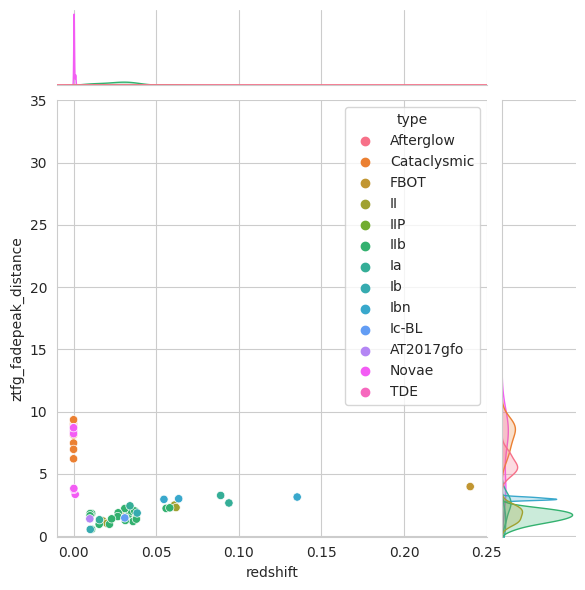

In [ ]:
JG1 = sns.jointplot(data=df_rates, x='redshift', y='ztfg_fadepeak_distance', hue='type',markers='type')
JG1.ax_marg_x.set_xlim(-0.01,0.25), JG1.ax_marg_y.set_ylim(-0.05,35)
# JG1.ax_marg_x.set_xlim(-0.3,None), JG1.ax_marg_y.set_ylim(-1,None)

In [ ]:
# filters = ['ztfg', 'ztfr', 'ztfi'] 
# y_column = 'redshift'
# x_columns = {
#     'ztfg': 'ztfg_risepeak_distance',
#     'ztfr': 'ztfr_risepeak_distance',
#     'ztfi': 'ztfi_risepeak_distance'
# }

# fig = plt.figure(figsize=(10, 15))
# gs = fig.add_gridspec(6, 1, height_ratios=[4,3] * 3, hspace=0.5)

# handles, labels = [], []

# for i, filt in enumerate(filters):

#     x_column = x_columns[filt]

#     ax_scatter = fig.add_subplot(gs[i*2, 0])
#     scatter = sns.scatterplot(data=df_rates.sort_values('redshift'), x=x_column, y=y_column, hue='type', style='type', s=150, ax=ax_scatter, palette=colors_dict)
#     ax_scatter.set_title(f'{filt}')
#     ax_scatter.set_ylabel('Redshift')
#     ax_scatter.set_xlabel(None)

#     if i == 0:
#         handles, labels = ax_scatter.get_legend_handles_labels()
#     ax_scatter.legend_.remove()
    
#     ax_hist = fig.add_subplot(gs[i*2+1, 0], sharex=ax_scatter)
#     #ax_hist.hist(df_rates[x_column], bins=30, color='gray', alpha=0.7)
#     sns.histplot(data=df_rates.sort_values('redshift'), x=x_column, hue='type', multiple='stack', ax=ax_hist, bins=31,legend=False)
#     ax_hist.set_xlabel('Avg. Distance to Model')
#     #ax_hist.set_ylabel('Count')

# fig.legend(handles=handles, labels=labels, title='Type', bbox_to_anchor=(0.9, 0.625), loc="upper left")
# fig.suptitle('Rise vs Peak Metric Distance', y=0.91)
# plt.tight_layout(rect=[0, 0, 0.85, 1])
# plt.savefig(f'figures/rise_vs_peak_metric_distance{ext}', bbox_inches='tight') if savefigs else None
# plt.show()

In [ ]:
# filters = ['ztfg', 'ztfr', 'ztfi'] 
# y_column = 'redshift'
# x_columns = {
#     'ztfg': 'ztfg_fadepeak_distance',
#     'ztfr': 'ztfr_fadepeak_distance',
#     'ztfi': 'ztfi_fadepeak_distance'
# }

# fig = plt.figure(figsize=(10, 15))
# gs = fig.add_gridspec(6, 1, height_ratios=[4,3] * 3, hspace=0.5)

# handles, labels = [], []

# for i, filt in enumerate(filters):

#     x_column = x_columns[filt]

#     ax_scatter = fig.add_subplot(gs[i*2, 0])
#     scatter = sns.scatterplot(data=df_rates.sort_values('redshift'), x=x_column, y=y_column, hue='type', style='type', s=150, ax=ax_scatter)
#     ax_scatter.set_title(f'{filt}')
#     ax_scatter.set_ylabel('Redshift')
#     ax_scatter.set_xlabel(None)

#     if i == 0:
#         handles, labels = ax_scatter.get_legend_handles_labels()
#     ax_scatter.legend_.remove()
    
#     ax_hist = fig.add_subplot(gs[i*2+1, 0], sharex=ax_scatter)
#     #ax_hist.hist(df_rates[x_column], bins=30, color='gray', alpha=0.7)
#     sns.histplot(data=df_rates.sort_values('redshift'), x=x_column, hue='type', multiple='stack', ax=ax_hist, bins=31,legend=False)
#     ax_hist.set_xlabel('Avg. Distance to Model')
#     #ax_hist.set_ylabel('Count')

# fig.legend(handles=handles, labels=labels, title='Type', bbox_to_anchor=(0.9, 0.625), loc="upper left")

# plt.tight_layout(rect=[0, 0, 0.85, 1])
# fig.suptitle('Fade vs Peak Metric Distance', y=0.91)
# plt.savefig(f'figures/fade_vs_peak_metric_distance{ext}', bbox_inches='tight') if savefigs else None
# plt.show()